In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.utils import shuffle
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split,  GridSearchCV 
from sklearn.metrics import classification_report
import re



warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\d.sanabriam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d.sanabriam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\d.sanabriam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\d.sanabriam\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
import json 
import bson
import tweepy
import time
from datetime import datetime
from pathlib import Path

### Paso 1. Creación de la Base Gold Estándar
Contiene 1.031 cuentas influenciadoras en twitter con perfiles públicos, seleccionadas desde la página https://www.quanticotrends.com/top-5000-usuarios-colombianos-mas-influyentes-en-twitter y se pobló la información de las variables profesión, edad y género a criterio experto.

In [5]:
df=pd.read_excel("BasePoblada1034_Agrupada.xlsx", sheet_name= "Bases")
df.head()

,nombre,id,usuario,sexo,profesion,edad,status,texto,filtro,Rango Edad,Clase Agrupada Profesión
0,NicolÃ¡s EstupiÃ±Ã¡n ðŸ‡¨ðŸ‡´,727453812,@nico_estupinan,H,ingeniero civil,44,0.0,RT @felipe_ramir: Hoy inician las pruebas pilo...,0,40-50,Ingenieria
1,AndrÃ©s Valencia PinzÃ³n,2231696656,@AndrsValencia9,H,economista,54,0.0,"""Si ha estado votando por polÃ­ticos que prome...",0,>50,Economista/Matematico/Adm. Empresas
2,LAURA DE LEÃ“N,187579797,@lauramarceladlc,M,actor,31,0.0,ðŸ—£,0,30-40,Actor/Actriz/Cantante/Musico
3,Julio HernÃ¡n Correal Triana,202273341,@JulioHCorreal,H,profesor,63,0.0,Mi nueva columna en Las 2 Orillas \nhttps://t....,0,>50,Profesor
4,Fabio Poveda,903326095,@FabioPovedaRuiz,H,Comunicador Social/Periodista,42,0.0,RT @nelsonpatron_: De manera articulada trabaj...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo


In [6]:
df["edad"] = np.where(df["edad"] == "ND", np.nan, df["edad"]  )  
df["edad"] = df["edad"].apply(lambda x : float(x)) 
df['edad2'] = df['Rango Edad'].apply(lambda x : x[-2:] ).apply(lambda x : float(x))
df["edad"] = np.where(df["edad"] == 0, df['edad2'] , df["edad"] )
df = df.drop(columns = ['edad2']) 

## Paso 2. Asignación a Criterio Experto del nivel de ingresos:
a. Se realizó la extracción de información de los salarios según las profesiones de la página https://co.talent.com/salary correspondiente a una página de reclutamiento laboral.  
b. Se consultó en el DANE la brecha salarial según género, en donde para las mujeres se encuentra una brecha salarial 23.9% por debajo con respecto al salario que devengan los hombres.   
c. Se consultó en el DANE la brecha salarial según género y edad, agrupado por rangos de edad. 

In [7]:
#https://co.talent.com/salary
ingresos_prof = {
'Ingenieria': 2379950,
'Economista/Matematico/Adm. Empresas': 2026245,
'Actor/Actriz/Cantante/Musico' : 1781101, 
'Profesor': 2122409, 
'Comunicador Social/Periodista/Presentador/Modelo' : 1728868, 
'Politico' : 7000000 , 
'Deportista' : 2533639 , 
'Sociologia/Antropología/Filosofia' : 2508395, 
'Policia/Militar/Investigador': 1744338 , 
'Medicina': 3122029,
'Biologo': 2100000,
'Cocinero/Chef' : 1292593,
'Marketing/Publicidad/Modas' : 2208186 , 
'Escritor ' :  1500000 , 
'Abogado' : 2500000 , 
'Asesor Espiritual' :  (1230000 + 1072000) / 2 #promedio colombiano de ingresos mensuales DANE
}
ingresos_prof

{'Ingenieria': 2379950,
 'Economista/Matematico/Adm. Empresas': 2026245,
 'Actor/Actriz/Cantante/Musico': 1781101,
 'Profesor': 2122409,
 'Comunicador Social/Periodista/Presentador/Modelo': 1728868,
 'Politico': 7000000,
 'Deportista': 2533639,
 'Sociologia/Antropología/Filosofia': 2508395,
 'Policia/Militar/Investigador': 1744338,
 'Medicina': 3122029,
 'Biologo': 2100000,
 'Cocinero/Chef': 1292593,
 'Marketing/Publicidad/Modas': 2208186,
 'Escritor ': 1500000,
 'Abogado': 2500000,
 'Asesor Espiritual': 1151000.0}

In [8]:
#dane: Ingreso laboral promedio brecha Profesional (H-M)
brecha_profesion = {
    "M": 0.239,
    "H": 0
}
brecha_profesion

{'M': 0.239, 'H': 0}

In [9]:
#por edad  (Hombres - Mujeres) brecha 
#El ingreso laboral promedio e ingreso laboral promedio por hora se presentan en miles de pesos. Por efecto del redondeo en miles, los totales pueden
#diferir ligeramente.
breacha_edades=[
['15 a 24',  769, 727, 5.4/100],
['25 a 34',  1266, 1149, 9.2/100],
['35 a 44',  1466, 1246, 15.0/100], 
['45 a 54',  1360, 1150, 15.4/100],
['55 o más años', 1133, 888, 21.6/100]
]
brechas_edad = pd.DataFrame(breacha_edades,columns =["rangos_edad", "ing_hombres", "ing_mujeres", "brecha"])
brechas_edad

,rangos_edad,ing_hombres,ing_mujeres,brecha
0,15 a 24,769,727,0.054
1,25 a 34,1266,1149,0.092
2,35 a 44,1466,1246,0.150
3,45 a 54,1360,1150,0.154
4,55 o más años,1133,888,0.216


In [10]:
#crecimiento de ingreso promedio por edad
#hombres 
t1_hombres =  brechas_edad.ing_hombres.tolist()[1:]
t_hombres = brechas_edad.ing_hombres.tolist()[:-1]
hombres = [round((t/t1)-1,2) for t, t1 in zip(t1_hombres, t_hombres)]
hombres_final = [1]
hombres_final.extend(hombres)
#mujeres 
t1_mujeres =  brechas_edad.ing_mujeres.tolist()[1:]
t_mujeres = brechas_edad.ing_mujeres.tolist()[:-1]
mujeres = [round((t/t1)-1,2) for t, t1 in zip(t1_mujeres, t_mujeres)]
mujeres_final = [1]
mujeres_final.extend(mujeres)

In [11]:
brechas_edad["crecimiento_ing_hombre_edad"] = hombres_final
brechas_edad["crecimiento_ing_mujer_edad"] = mujeres_final
brechas_edad

,rangos_edad,ing_hombres,ing_mujeres,brecha,crecimiento_ing_hombre_edad,crecimiento_ing_mujer_edad
0,15 a 24,769,727,0.054,1.00,1.00
1,25 a 34,1266,1149,0.092,0.65,0.58
2,35 a 44,1466,1246,0.150,0.16,0.08
3,45 a 54,1360,1150,0.154,-0.07,-0.08
4,55 o más años,1133,888,0.216,-0.17,-0.23


In [12]:
def porc_crecimiento_ing_edad (x, edad, sexo, crecimiento_ing_hombre_edad):
  if x[sexo] == "H":
    if x[edad] <= 24: 
      x[crecimiento_ing_hombre_edad] = 0
    elif x[edad] <= 34: 
      x[crecimiento_ing_hombre_edad] = 0.65
    elif x[edad] <= 44: 
      x[crecimiento_ing_hombre_edad] = 0.16
    elif x[edad] <= 54: 
      x[crecimiento_ing_hombre_edad] = -0.07
    else: 
      x[crecimiento_ing_hombre_edad] = -0.17
  else:
    if x[edad] <= 24: 
      x[crecimiento_ing_hombre_edad] = 0
    elif x[edad] <= 34: 
      x[crecimiento_ing_hombre_edad] = 0.58
    elif x[edad] <= 44: 
      x[crecimiento_ing_hombre_edad] = 0.08
    elif x[edad] <= 54: 
      x[crecimiento_ing_hombre_edad] = -0.08
    else: 
      x[crecimiento_ing_hombre_edad] = -0.23

  return x 

In [13]:
def porc_edad_genero (x, edad, sexo, porc_edad_gen):
  if x[sexo] == "M":
    if x[edad] <= 24: 
      x[porc_edad_gen] = 0.054
    elif x[edad] <= 34: 
      x[porc_edad_gen] = 0.092
    elif x[edad] <= 44: 
      x[porc_edad_gen] = 0.150
    elif x[edad] <= 54: 
      x[porc_edad_gen] = 0.154
    else: 
      x[porc_edad_gen] = 0.216
  else:
    x[porc_edad_gen] = 0
  return x 

## Paso 3. Consolidación del Dataframe:
Se agrega al dataframe la variable de ingresos promedio por profesión, brechas en función de profesión, edad y género.

In [14]:
df["ingresos_promedio_profesion"] = df["Clase Agrupada Profesión"].apply(lambda x : ingresos_prof[x] )
df["brecha_profesion"] = df["sexo"].apply(lambda x : brecha_profesion[x] )
df = df.apply(lambda x : porc_edad_genero(x, 'edad', 'sexo','porc_edad_gen' ), axis = 1 ) 
df = df.apply(lambda x : porc_crecimiento_ing_edad(x, 'edad', 'sexo','crecimiento_ing_edad' ), axis = 1 ) 
df.head()

,nombre,id,usuario,sexo,profesion,edad,status,texto,filtro,Rango Edad,Clase Agrupada Profesión,ingresos_promedio_profesion,brecha_profesion,porc_edad_gen,crecimiento_ing_edad
0,NicolÃ¡s EstupiÃ±Ã¡n ðŸ‡¨ðŸ‡´,727453812,@nico_estupinan,H,ingeniero civil,44.0,0.0,RT @felipe_ramir: Hoy inician las pruebas pilo...,0,40-50,Ingenieria,2379950.0,0.000,0.000,0.16
1,AndrÃ©s Valencia PinzÃ³n,2231696656,@AndrsValencia9,H,economista,54.0,0.0,"""Si ha estado votando por polÃ­ticos que prome...",0,>50,Economista/Matematico/Adm. Empresas,2026245.0,0.000,0.000,-0.07
2,LAURA DE LEÃ“N,187579797,@lauramarceladlc,M,actor,31.0,0.0,ðŸ—£,0,30-40,Actor/Actriz/Cantante/Musico,1781101.0,0.239,0.092,0.58
3,Julio HernÃ¡n Correal Triana,202273341,@JulioHCorreal,H,profesor,63.0,0.0,Mi nueva columna en Las 2 Orillas \nhttps://t....,0,>50,Profesor,2122409.0,0.000,0.000,-0.17
4,Fabio Poveda,903326095,@FabioPovedaRuiz,H,Comunicador Social/Periodista,42.0,0.0,RT @nelsonpatron_: De manera articulada trabaj...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.000,0.000,0.16


In [15]:
df["ingresos_promedio_profesion_final"] = df.ingresos_promedio_profesion*(1-df.porc_edad_gen)*(1+df.crecimiento_ing_edad)*(1-df.brecha_profesion)
df.head()

,nombre,id,usuario,sexo,profesion,edad,status,texto,filtro,Rango Edad,Clase Agrupada Profesión,ingresos_promedio_profesion,brecha_profesion,porc_edad_gen,crecimiento_ing_edad,ingresos_promedio_profesion_final
0,NicolÃ¡s EstupiÃ±Ã¡n ðŸ‡¨ðŸ‡´,727453812,@nico_estupinan,H,ingeniero civil,44.0,0.0,RT @felipe_ramir: Hoy inician las pruebas pilo...,0,40-50,Ingenieria,2379950.0,0.000,0.000,0.16,2.760742e+06
1,AndrÃ©s Valencia PinzÃ³n,2231696656,@AndrsValencia9,H,economista,54.0,0.0,"""Si ha estado votando por polÃ­ticos que prome...",0,>50,Economista/Matematico/Adm. Empresas,2026245.0,0.000,0.000,-0.07,1.884408e+06
2,LAURA DE LEÃ“N,187579797,@lauramarceladlc,M,actor,31.0,0.0,ðŸ—£,0,30-40,Actor/Actriz/Cantante/Musico,1781101.0,0.239,0.092,0.58,1.944537e+06
3,Julio HernÃ¡n Correal Triana,202273341,@JulioHCorreal,H,profesor,63.0,0.0,Mi nueva columna en Las 2 Orillas \nhttps://t....,0,>50,Profesor,2122409.0,0.000,0.000,-0.17,1.761599e+06
4,Fabio Poveda,903326095,@FabioPovedaRuiz,H,Comunicador Social/Periodista,42.0,0.0,RT @nelsonpatron_: De manera articulada trabaj...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.000,0.000,0.16,2.005487e+06


## Paso 4. Análisis Descriptivo

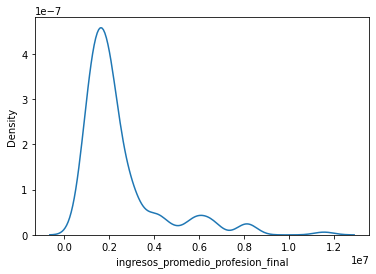

In [16]:
sns.kdeplot(df["ingresos_promedio_profesion_final"]);

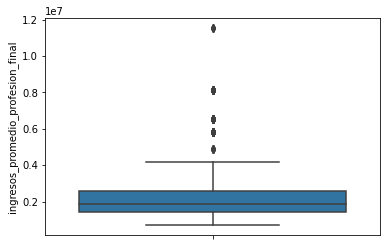

In [17]:
sns.boxplot(y=df["ingresos_promedio_profesion_final"]);

Los ingresos promedio por profesión están concentrados en valores inferiores a $4 millones de pesos.

In [18]:
#ingreso en miles
df["ingresos_promedio_profesion_final"].apply(lambda x : x/1000).describe()

count     1031.000000
mean      2436.168890
std       1787.394305
min        689.100720
25%       1424.896163
50%       1887.510726
75%       2591.284070
max      11550.000000
Name: ingresos_promedio_profesion_final, dtype: float64

El análisis estadístico de la variable ingresos promedio por profesión nos dice que la media es  2.4 millones de pesos y el percentil 75 esta sobre  2.6 millones de pesos , tenemos un valor mínimo de 0.7 millones de pesos y un máximo de $ 11.5 millones de pesos.

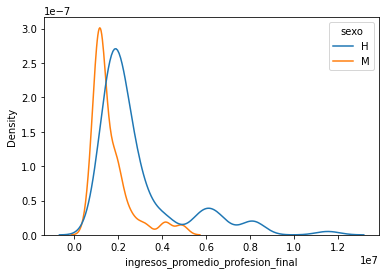

In [19]:
sns.kdeplot(df["ingresos_promedio_profesion_final"], hue = df["sexo"]);

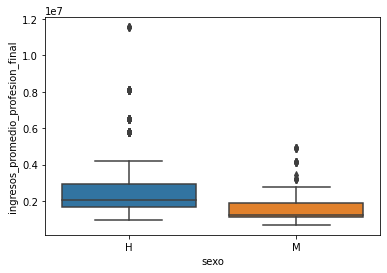

In [20]:
sns.boxplot(y=df["ingresos_promedio_profesion_final"], x = df["sexo"]);

In [21]:
df.groupby("sexo")["ingresos_promedio_profesion_final"].describe().T

sexo,H,M
count,6.520000e+02,3.790000e+02
mean,2.904693e+06,1.630160e+06
std,1.995267e+06,9.049989e+05
min,9.553300e+05,6.891007e+05
25%,1.656424e+06,1.148501e+06
50%,2.066077e+06,1.244274e+06
75%,2.939021e+06,1.887511e+06
max,1.155000e+07,4.890186e+06


Se evidencia que al analizar la variable ingresos promedio por profesión segmentado por género enmarca la brecha salarial, donde el ingreso es mayor cuando se trata de hombres con un ingreso promedio de 2.9 millones de pesos y cuando se trata de mujeres 1.63 millones de pesos.

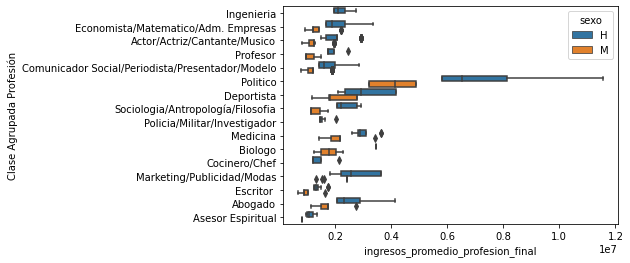

In [22]:
sns.boxplot(x=df["ingresos_promedio_profesion_final"], y = df["Clase Agrupada Profesión"], hue = df["sexo"]);

Respecto a la diferencia salarial entre hombres y mujeres de acuerdo a su profesión, se evidencia que en general que los hombres ganan más que las mujeres en cualquiera de las profesiones evaluadas en este estudio, encontrando una brecha salarial evidente cuando se trata de políticos.

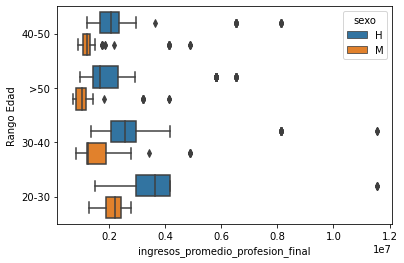

In [23]:
sns.boxplot(x=df["ingresos_promedio_profesion_final"], y = df["Rango Edad"], hue = df["sexo"]);

Analizando la diferencia salarial por rango de edad y género, encontramos que en cualquier rango de edad los hombres tienen mayor ingreso que las mujeres, sin embargo también se evidencia que en el rango de 20 a 30 años se da el mayor de ingresos, mientras para los individuos con más de 40 años se presenta un comportamiento decreciente en su ingreso.

## Paso 5. Segmentación de la variable Nivel de Ingresos
Se consideraron los siguientes percentiles para asignar el nivel de ingresos:  
a. Los casos desde percentil 60 en adelante se asignaron al Nivel de Ingresos Alto.  
b. Los casos del percentil 40 a 59 en adelante se asignaron al Nivel de Ingresos Medio.  
c. Los casos del percentil 40 hacia abajo, se asignaron al Nivel de Ingresos Bajo.  

In [24]:
def nivel_ingresos (x, sexo, ingreso, nivel):
  if x[sexo] == "M":
    if x[ingreso] >= np.percentile( df[df["sexo"] =="M"]["ingresos_promedio_profesion_final"], 60):
      x[nivel] = "alto"
    elif x[ingreso] >= np.percentile( df[df["sexo"] =="M"]["ingresos_promedio_profesion_final"], 40):
       x[nivel] = "medio"
    else:
      x[nivel] = "bajo"
  else:
    if x[ingreso] >= np.percentile( df[df["sexo"] =="H"]["ingresos_promedio_profesion_final"], 60):
      x[nivel] = "alto"
    elif x[ingreso] >= np.percentile( df[df["sexo"] =="H"]["ingresos_promedio_profesion_final"], 40):
       x[nivel] = "medio"
    else:
      x[nivel] = "bajo"
  return x 

In [25]:
df = df.apply(lambda x : nivel_ingresos(x, 'sexo','ingresos_promedio_profesion_final', 'nivel_ingreso' ), axis = 1 ) 
df.head()

,nombre,id,usuario,sexo,profesion,edad,status,texto,filtro,Rango Edad,Clase Agrupada Profesión,ingresos_promedio_profesion,brecha_profesion,porc_edad_gen,crecimiento_ing_edad,ingresos_promedio_profesion_final,nivel_ingreso
0,NicolÃ¡s EstupiÃ±Ã¡n ðŸ‡¨ðŸ‡´,727453812,@nico_estupinan,H,ingeniero civil,44.0,0.0,RT @felipe_ramir: Hoy inician las pruebas pilo...,0,40-50,Ingenieria,2379950.0,0.000,0.000,0.16,2.760742e+06,alto
1,AndrÃ©s Valencia PinzÃ³n,2231696656,@AndrsValencia9,H,economista,54.0,0.0,"""Si ha estado votando por polÃ­ticos que prome...",0,>50,Economista/Matematico/Adm. Empresas,2026245.0,0.000,0.000,-0.07,1.884408e+06,bajo
2,LAURA DE LEÃ“N,187579797,@lauramarceladlc,M,actor,31.0,0.0,ðŸ—£,0,30-40,Actor/Actriz/Cantante/Musico,1781101.0,0.239,0.092,0.58,1.944537e+06,alto
3,Julio HernÃ¡n Correal Triana,202273341,@JulioHCorreal,H,profesor,63.0,0.0,Mi nueva columna en Las 2 Orillas \nhttps://t....,0,>50,Profesor,2122409.0,0.000,0.000,-0.17,1.761599e+06,bajo
4,Fabio Poveda,903326095,@FabioPovedaRuiz,H,Comunicador Social/Periodista,42.0,0.0,RT @nelsonpatron_: De manera articulada trabaj...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.000,0.000,0.16,2.005487e+06,medio


## Paso 6. Análisis Descriptivo de las variables sociodemográficas:

-La base contiene mayor número de usuarios hombres.  
-Se evidencia donde esta la mayor concentración de datos esta dado en personas mayores de 50 años, seguidos de las personas entre 30 y 40 años.  
-En cuanto a profesiones la base contiene más comunicadores sociales, periodistas, actrices, modelos y políticos, lo cual responde a la naturaleza de la base seleccionada dado que son perfiles públicos.  
-El nivel de ingresos está dado por los niveles bajo y alto.

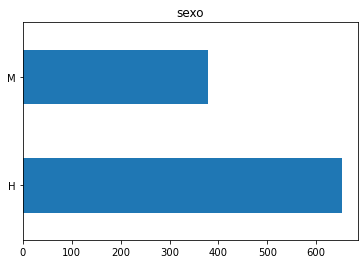

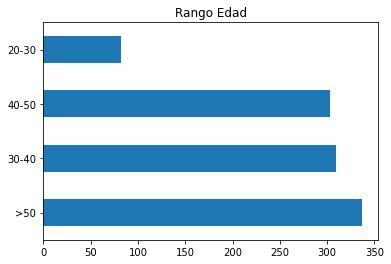

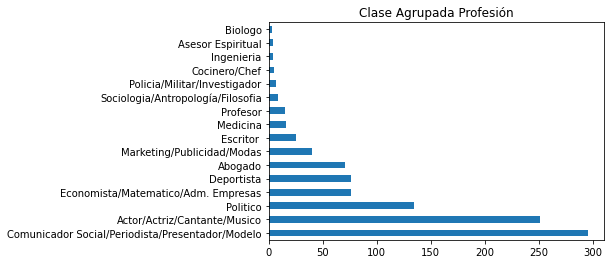

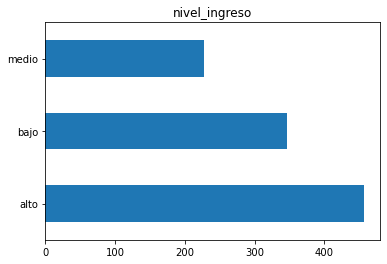

In [26]:
vars = ["sexo", "Rango Edad", "Clase Agrupada Profesión", "nivel_ingreso"]
for variables in vars:
  df[variables].value_counts().plot(kind = "barh", title = variables)
  plt.show()

## Paso 7. Descarga de Información desde la API de Twitter Developer en Mongos para las 1.031 cuentas seleccionadas en el estudio.

In [27]:
t= open('tweets.bson', 'rb')
t_1= bson.decode_all(t.read())
twts = pd.DataFrame(t_1)
twts.head()

,_id,created_at,favorite_count,hashtags,id,id_str,lang,retweet_count,source,text,...,in_reply_to_status_id,possibly_sensitive,coordinates,geo,place,withheld_in_countries,withheld_copyright,withheld_scope,favorited,retweeted
0,62bb83dd99461d5b8c96a73c,Wed May 18 16:09:00 +0000 2022,10.0,[],1526958036232945671,1526958036232945671,es,1.0,"<a href=""http://twitter.com/download/iphone"" r...",Crecimiento Colombia primer trimestre 2022: 8....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62bb83dd99461d5b8c96a73d,Mon May 16 17:13:33 +0000 2022,NaN,[{'text': 'Atento'}],1526249508086157313,1526249508086157313,es,152.0,"<a href=""http://twitter.com/download/iphone"" r...",RT @larepublica_co: #Atento | El PIB del prime...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62bb83dd99461d5b8c96a73e,Thu May 12 00:40:29 +0000 2022,40.0,[],1524550043734319104,1524550043734319104,es,15.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Colombia ya llegó a los niveles de normalidad ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62bb83dd99461d5b8c96a73f,Sun May 01 12:06:07 +0000 2022,19.0,[],1520736319860875264,1520736319860875264,es,4.0,"<a href=""http://twitter.com/download/iphone"" r...","""Si ha estado votando por políticos que promet...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62bb83dd99461d5b8c96a740,Wed Apr 27 16:12:41 +0000 2022,1.0,[],1519348821838508032,1519348821838508032,es,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Desigualdad de ingresos se redujo incluso por ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
twts.columns

Index(['_id', 'created_at', 'favorite_count', 'hashtags', 'id', 'id_str',
       'lang', 'retweet_count', 'source', 'text', 'urls', 'user',
       'user_mentions', 'media', 'retweeted_status', 'truncated',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'in_reply_to_screen_name', 'in_reply_to_user_id',
       'in_reply_to_status_id', 'possibly_sensitive', 'coordinates', 'geo',
       'place', 'withheld_in_countries', 'withheld_copyright',
       'withheld_scope', 'favorited', 'retweeted'],
      dtype='object')

In [31]:
def user_id(data):
    # print(data)
    return data['id']

def user_screen_name(data):
    # print(data)
    return data['screen_name']


def created(data):
    # print(data)
    return data['created_at']

twts['user_id']=twts['user'].apply(user_id)
twts['user_screen_name']=twts['user'].apply(user_screen_name)
twts['created_at']=twts['user'].apply(created)

In [32]:
twts[['id', 'text', 'user_id', 'user_screen_name','created_at']]

,id,text,user_id,user_screen_name,created_at
0,1526958036232945671,Crecimiento Colombia primer trimestre 2022: 8....,2231696656,AndrsValencia9,Wed Dec 18 13:51:43 +0000 2013
1,1526249508086157313,RT @larepublica_co: #Atento | El PIB del prime...,2231696656,AndrsValencia9,Wed Dec 18 13:51:43 +0000 2013
2,1524550043734319104,Colombia ya llegó a los niveles de normalidad ...,2231696656,AndrsValencia9,Wed Dec 18 13:51:43 +0000 2013
3,1520736319860875264,"""Si ha estado votando por políticos que promet...",2231696656,AndrsValencia9,Wed Dec 18 13:51:43 +0000 2013
4,1519348821838508032,Desigualdad de ingresos se redujo incluso por ...,2231696656,AndrsValencia9,Wed Dec 18 13:51:43 +0000 2013
...,...,...,...,...,...
3009750,890721368488202241,Con Talasa mejora la calidad de vida de comuni...,64839766,JuanManSantos,Tue Aug 11 22:07:56 +0000 2009
3009751,890720398408548352,Talasa es un proyecto sostenible ubicado en Ca...,64839766,JuanManSantos,Tue Aug 11 22:07:56 +0000 2009
3009752,890719703634776064,En Comisión Intersectorial de Infraestructura ...,64839766,JuanManSantos,Tue Aug 11 22:07:56 +0000 2009
3009753,890691646047866880,Recibí en Casa de Nariño 74 becarios asiáticos...,64839766,JuanManSantos,Tue Aug 11 22:07:56 +0000 2009


In [37]:
df_count=twts.groupby(['created_at']).count()

In [38]:
df_count.to_excel('df_count.xlsx')

## Paso 8. Preprocesamiento de los datos:
Fue aplicado el siguiente tratamiento en términos de expresiones regulares:
1.	Reemplazo de retweets (RT) por espacios en blanco.
2.	Reemplazo de hashtag(#) por la palabra hash.
3.	Reemplazo de menciones(@) por la palabra menc.
4.	Corrección a palabras abreviadas, por ejemplo, ‘d’ por ‘de’.
5.	Remoción de caracteres especiales.
6.	Remoción de dígitos entre [0 y 9] descritos en la abreviatura ‘\d+’.
7.	Remoción de espacios múltiples descritos en la abreviatura ‘\\s+’.

In [39]:
def indices (base, indice):
  return base.set_index(indice)

In [40]:
# Sustituimos hashtag por {hash}
def remove_hashtags(df):
    return " ".join(['{hash}' if word.startswith('#') else word for word in df.split()])

In [41]:
# Sustituimos menciones por {mencion}
def remove_mentions(df):
    return " ".join(['{menc}' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

In [42]:
textos =  twts[["user_id","text"]]

In [43]:
textos.shape

(3009755, 2)

In [44]:
textos.drop_duplicates(inplace=True)
textos.shape

(2796707, 2)

In [73]:
textos= textos.sample(n=100000, random_state=123, replace=True)

textos.shape

(100000, 9)

In [74]:
def palabras_repetidas (x):
  todas_palabras = [palabra for texto in x for palabra in texto]
  dicc = {}
  for palabra in set(todas_palabras):
    c=0
    for repetida in todas_palabras:
      if palabra == repetida:
        c+=1
    dicc[palabra] = c 
  return dicc

In [75]:
pip install pyspellchecker

In [76]:
from spellchecker import SpellChecker
spell = SpellChecker(language= 'es', distance=1)
def corregir_palabras(text):
  corregir = spell.unknown(text.split())
  palabras = []
  for palabra in text.split():
    if palabra in corregir and 'hash' not in palabra and 'menc' not in palabra:
      if spell.correction(palabra) is not None:
        palabras.append(spell.correction(palabra))
      else:
        palabras.append(palabra)
    else:
      palabras.append(palabra)
  return ' '.join(palabras)

In [77]:
def fix_abbr(x):
  abbrevs =   {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
  return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in x.split()])

In [78]:
from nltk import SnowballStemmer

In [79]:
def eliminar_rt(text):
  if text.startswith('RT'):
    text = ''
  return text

In [80]:
def maxima_long_text (text):
  return max([len(i) for i in text.split()])

In [81]:
#ejemplo
import es_core_news_sm
nlp = es_core_news_sm.load()
doc = nlp("El copal se usa principalmente para sahumar en distintas ocasiones como lo son las fiestas religiosas.")
print([(w.text, w.pos_) for w in doc])

[('El', 'DET'), ('copal', 'NOUN'), ('se', 'PRON'), ('usa', 'VERB'), ('principalmente', 'ADV'), ('para', 'ADP'), ('sahumar', 'VERB'), ('en', 'ADP'), ('distintas', 'DET'), ('ocasiones', 'NOUN'), ('como', 'SCONJ'), ('lo', 'PRON'), ('son', 'AUX'), ('las', 'DET'), ('fiestas', 'NOUN'), ('religiosas', 'ADJ'), ('.', 'PUNCT')]


In [82]:
def conteo_verbos (text):
  nlp = es_core_news_sm.load()
  doc = nlp(text)
  return len([ w.pos_ for w in doc  if w.pos_ == 'VERB'])

In [83]:
def conteo_adjetivos (text):
  nlp = es_core_news_sm.load()
  doc = nlp(text)
  return len([ w.pos_ for w in doc  if w.pos_ == 'ADJ'])

In [84]:
def tratar_texto(text):
  text = eliminar_rt(text)
  text  = " ".join([j for i  in text.split() for j in i.split() if "https:" not in j ])
  text = text.lower()

  text = remove_hashtags(text)
  text = remove_mentions(text)
  text = fix_abbr(text)

  text = re.sub(r"[^a-zA-Z0-9ñáéíóúü]", " ", text)
  text = re.sub("\d+", ' ', text)
  # Eliminación de espacios en blanco múltiples
  text = re.sub("\\s+", ' ', text)
  text = corregir_palabras(text)

  return text

In [85]:
def tokenize (text):
  words = word_tokenize(text)
  stemmer = SnowballStemmer('spanish')
  stop = stopwords.words("spanish")
  words = [t for t in words if t not in stop]
  stem = [stemmer.stem(w) for w in words]
  return stem 

In [86]:
# textos["conteo_verbos"] = textos.text.apply(lambda x : conteo_verbos(str(x)))
# textos["conteo_adjetivos"] = textos.text.apply(lambda x : conteo_adjetivos(str(x)))

In [87]:
textos["textos_tratado"] = textos.text.apply(lambda x : tratar_texto(str(x)))
textos["cantidad_palabras_total"] = textos.textos_tratado.apply(lambda x : len(x.split()))
textos["palabras_stop"] = textos.textos_tratado.apply(lambda x : [i for i in x.split() if i in stopwords.words("spanish")] )
textos["cantidad_palabras_stop"] = textos.palabras_stop.apply(lambda x : len(x))
textos["textos_tratado_sin_palabras_stop"] = textos.textos_tratado.apply(lambda x : [i for i in x.split() if i not in stopwords.words("spanish")] )
textos["cantidad_textos_tratado_sin_palabras_stop"] = textos.textos_tratado_sin_palabras_stop.apply(lambda x : len(x))
textos.head()

,user_id,text,textos_tratado,cantidad_palabras_total,palabras_stop,cantidad_palabras_stop,textos_tratado_sin_palabras_stop,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra
22852,101736223,@arleisonarcos Jajajajaja,menc jajajajaja,2,[],0,"[menc, jajajajaja]",2,10
1912191,16953563,Felinos... un gusto verte @lauratobonyepes bes...,felinos un gusto verte menc besos y abrazos ha...,12,"[un, y]",2,"[felinos, gusto, verte, menc, besos, abrazos, ...",10,7
216480,184665684,@mmeiselc Amiga mía! 😉,menc amiga mía,3,[mía],1,"[menc, amiga]",2,5
1386116,156457300,"Pensar es fácil, actuar muy difícil y poner lo...",pensar es fácil actuar muy difícil y poner los...,18,"[es, muy, y, los, en, es, lo, más, del]",9,"[pensar, fácil, actuar, difícil, poner, dos, e...",9,10
123279,210496169,Dije que iba a comer mucho dulce. Pues son las...,dije que iba a comer mucho dulce pues son las ...,22,"[que, a, mucho, son, las, de, la, y, no, más, ...",12,"[dije, iba, comer, dulce, pues, tarde, puedo, ...",10,7


In [88]:
textos["max_long_palabra"] = textos.textos_tratado_sin_palabras_stop.apply(lambda x : max([len(i) for i in x ]) if len(x) > 0 else 0)

In [89]:
textos = textos[textos.textos_tratado != '']
textos.shape


(100000, 9)

In [90]:
textos.head()

,user_id,text,textos_tratado,cantidad_palabras_total,palabras_stop,cantidad_palabras_stop,textos_tratado_sin_palabras_stop,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra
22852,101736223,@arleisonarcos Jajajajaja,menc jajajajaja,2,[],0,"[menc, jajajajaja]",2,10
1912191,16953563,Felinos... un gusto verte @lauratobonyepes bes...,felinos un gusto verte menc besos y abrazos ha...,12,"[un, y]",2,"[felinos, gusto, verte, menc, besos, abrazos, ...",10,7
216480,184665684,@mmeiselc Amiga mía! 😉,menc amiga mía,3,[mía],1,"[menc, amiga]",2,5
1386116,156457300,"Pensar es fácil, actuar muy difícil y poner lo...",pensar es fácil actuar muy difícil y poner los...,18,"[es, muy, y, los, en, es, lo, más, del]",9,"[pensar, fácil, actuar, difícil, poner, dos, e...",9,10
123279,210496169,Dije que iba a comer mucho dulce. Pues son las...,dije que iba a comer mucho dulce pues son las ...,22,"[que, a, mucho, son, las, de, la, y, no, más, ...",12,"[dije, iba, comer, dulce, pues, tarde, puedo, ...",10,7


## Paso 9. Análisis Descriptivos de los textos encontrados en Twitter:
a. En promedio la cantidad de palabras total por tweet está entre 14 y 18 palabras.   
b. Por texto se utilizan en promedio 6 stopwords por tweet.  
c. Se encuentra que los hombres, políticos, biólogos y las personas mayores de 50 años generan tweets con mayor cantidad de palabras.  
d. En el top 10 de las palabras utilizadas en los tweets, sin tener en cuenta menciones y hashtags, están gracias, hoy, Colombia, Rodolfo, lo cual corresponde al momento político en que se encontraba el país.

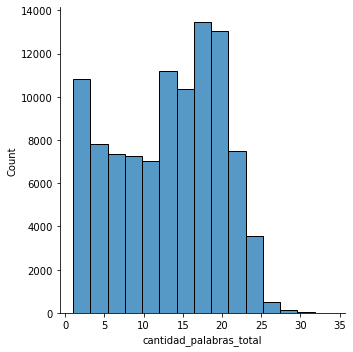

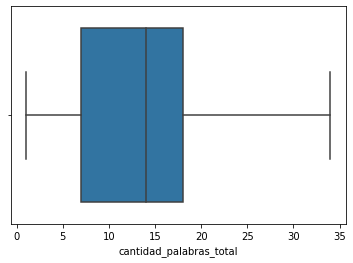

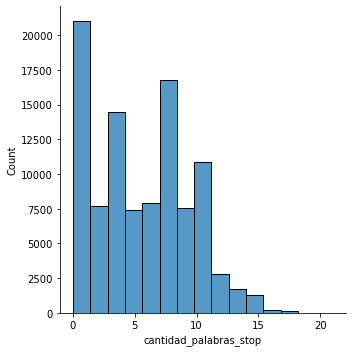

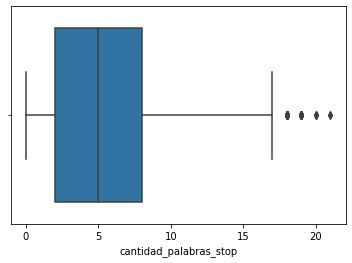

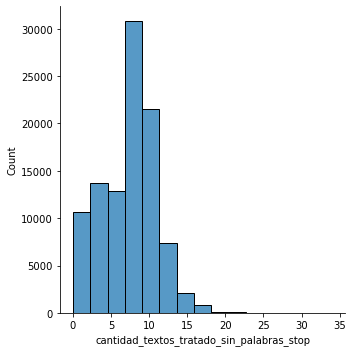

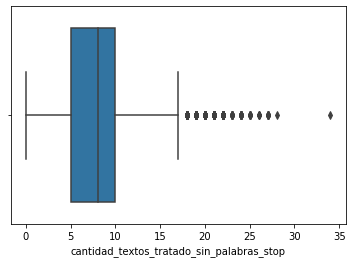

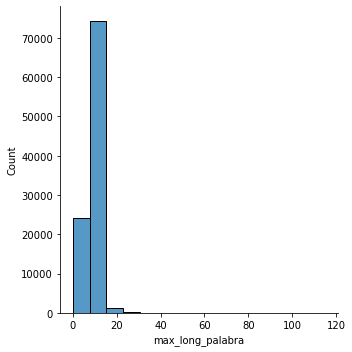

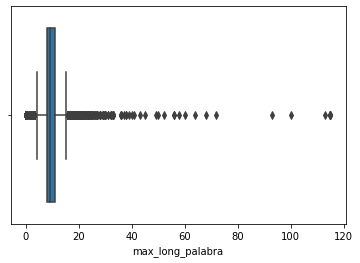

In [91]:
variables = [col for col in textos.columns if "cantidad" in col or "conteo" in col or 'max_long_palabra' == col]  
for variable in variables: 
  sns.displot(textos[variable], bins = 15)
  plt.show()
  sns.boxplot(textos[variable])
  plt.show()

In [92]:
textos[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
cantidad_palabras_total,100000.0,12.99046,6.595879,1.0,7.0,14.0,18.0,34.0
cantidad_palabras_stop,100000.0,5.47460,3.895806,0.0,2.0,5.0,8.0,21.0
cantidad_textos_tratado_sin_palabras_stop,100000.0,7.51586,3.569100,0.0,5.0,8.0,10.0,34.0
max_long_palabra,100000.0,9.39800,3.089536,0.0,8.0,9.0,11.0,115.0


In [93]:
textos.to_csv('textos')

In [94]:
textos_ind = indices (textos, "user_id")
df_ind = indices (df, "id")
df_final = textos_ind.merge(df_ind, how = 'inner', right_index=True, left_index=True  )
df_final.head()

,text,textos_tratado,cantidad_palabras_total,palabras_stop,cantidad_palabras_stop,textos_tratado_sin_palabras_stop,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra,nombre,usuario,...,texto,filtro,Rango Edad,Clase Agrupada Profesión,ingresos_promedio_profesion,brecha_profesion,porc_edad_gen,crecimiento_ing_edad,ingresos_promedio_profesion_final,nivel_ingreso
3376511,#PareceUnaNovela que estemos a 7 de enero y ya...,hash que estemos a de enero y ya hay una nueva...,20,"[que, estemos, a, de, y, ya, hay, una, en, est...",11,"[hash, enero, nueva, masacre, colombia, vez, c...",9,8,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,RT @fdbedout: #UnaVerdadUrgente que necesitamo...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo
3376511,#CambioEs lo que necesitan estos niños…\n\n¡No...,hash lo que necesitan estos niños no tienen co...,17,"[lo, que, estos, no, tienen, en, un, y, desde]",9,"[hash, necesitan, niños, colegio, estudian, ed...",8,10,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,RT @fdbedout: #UnaVerdadUrgente que necesitamo...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo
3376511,"#LasVictimasMerecen la verdad, justicia y sobr...",hash la verdad justicia y sobre todo que su vo...,21,"[la, y, sobre, todo, que, su, se, de, en, un, ...",12,"[hash, verdad, justicia, voz, nunca, deje, esc...",9,8,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,RT @fdbedout: #UnaVerdadUrgente que necesitamo...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo
3376511,#BuenaNoticiaSería que de manera rápida y sin ...,hash que de manera rápida y sin inconvenientes...,19,"[que, de, y, sin, se, el, a, de, los, de]",10,"[hash, manera, rápida, inconvenientes, logre, ...",9,14,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,RT @fdbedout: #UnaVerdadUrgente que necesitamo...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo
3376511,#ParaConfiar necesitamos que los responsables ...,hash necesitamos que los responsables de la de...,16,"[que, los, de, la, su, y, que, en]",8,"[hash, necesitamos, responsables, debacle, ele...",8,15,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,RT @fdbedout: #UnaVerdadUrgente que necesitamo...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo


In [95]:
df_final.shape

(97385, 24)

In [96]:
df_final.columns

Index(['text', 'textos_tratado', 'cantidad_palabras_total', 'palabras_stop',
       'cantidad_palabras_stop', 'textos_tratado_sin_palabras_stop',
       'cantidad_textos_tratado_sin_palabras_stop', 'max_long_palabra',
       'nombre', 'usuario', 'sexo', 'profesion', 'edad', 'status', 'texto',
       'filtro', 'Rango Edad', 'Clase Agrupada Profesión',
       'ingresos_promedio_profesion', 'brecha_profesion', 'porc_edad_gen',
       'crecimiento_ing_edad', 'ingresos_promedio_profesion_final',
       'nivel_ingreso'],
      dtype='object')

In [97]:
def densidades (df):
    for var in ["sexo", "Rango Edad", "Clase Agrupada Profesión","nivel_ingreso"]:
      cols = [col for col in df.columns if "cantidad" in col or "conteo" in col or 'max_long_palabra' == col] 
      f, ax = plt.subplots(3,2, figsize=(15,7))
      for i, col in enumerate(cols):
        sns.boxplot( x=df[col], y= df[var], ax = ax[i//2, i%2]) 
        plt.tight_layout()

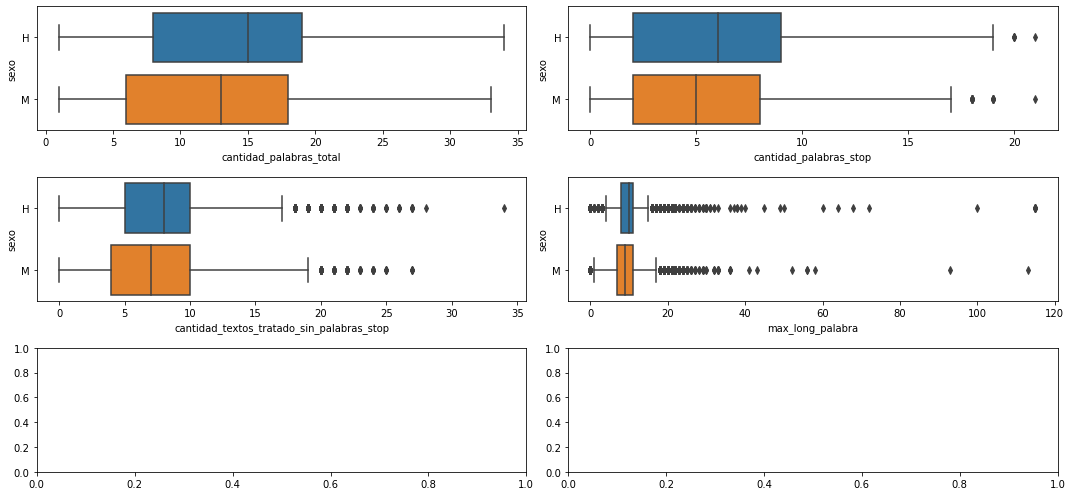

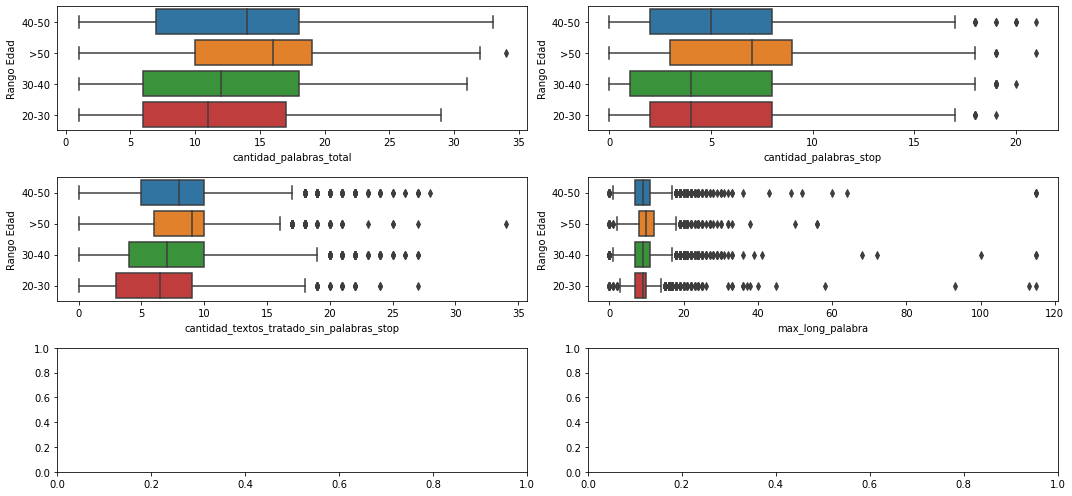

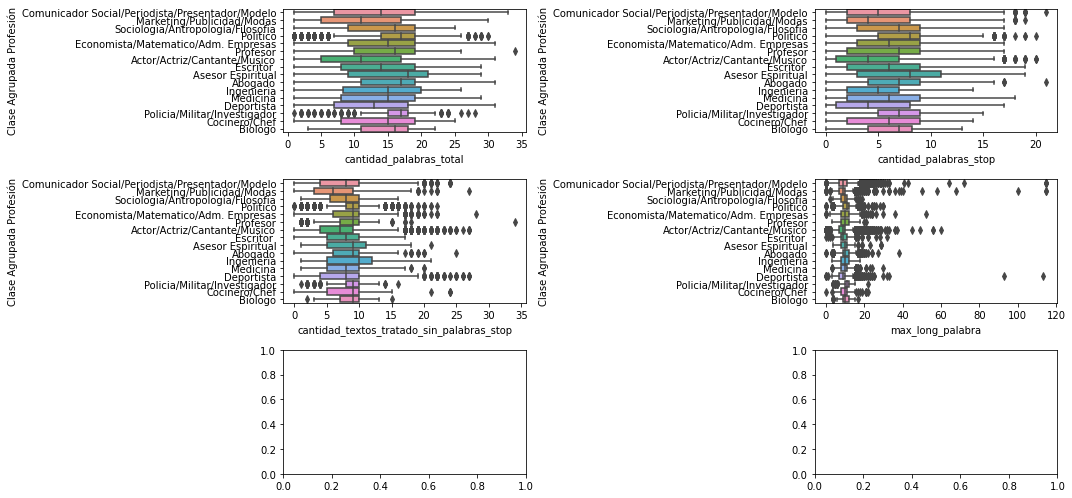

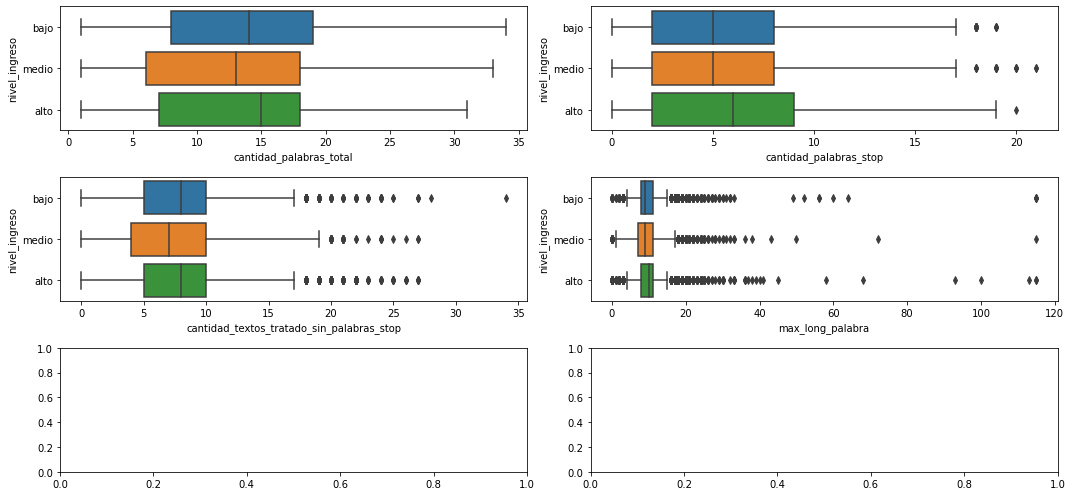

In [98]:
densidades(df_final)

In [99]:
df_final["texto_tokenizado"] = df_final["textos_tratado"].apply(lambda x : tokenize(str(x)))

In [100]:
conteo_palabras=palabras_repetidas(df_final.textos_tratado_sin_palabras_stop)

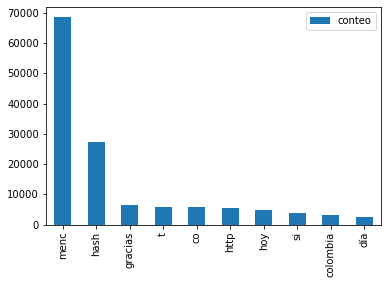

In [101]:
pd.DataFrame({"conteo": conteo_palabras.values()}, index = conteo_palabras.keys()).sort_values( by = "conteo", ascending = False)[:10].plot(kind="bar");

In [102]:
df_final.head()

,text,textos_tratado,cantidad_palabras_total,palabras_stop,cantidad_palabras_stop,textos_tratado_sin_palabras_stop,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra,nombre,usuario,...,filtro,Rango Edad,Clase Agrupada Profesión,ingresos_promedio_profesion,brecha_profesion,porc_edad_gen,crecimiento_ing_edad,ingresos_promedio_profesion_final,nivel_ingreso,texto_tokenizado
3376511,#PareceUnaNovela que estemos a 7 de enero y ya...,hash que estemos a de enero y ya hay una nueva...,20,"[que, estemos, a, de, y, ya, hay, una, en, est...",11,"[hash, enero, nueva, masacre, colombia, vez, c...",9,8,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo,"[hash, ener, nuev, masacr, colombi, vez, casan..."
3376511,#CambioEs lo que necesitan estos niños…\n\n¡No...,hash lo que necesitan estos niños no tienen co...,17,"[lo, que, estos, no, tienen, en, un, y, desde]",9,"[hash, necesitan, niños, colegio, estudian, ed...",8,10,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo,"[hash, necesit, niñ, colegi, estudi, edifici, ..."
3376511,"#LasVictimasMerecen la verdad, justicia y sobr...",hash la verdad justicia y sobre todo que su vo...,21,"[la, y, sobre, todo, que, su, se, de, en, un, ...",12,"[hash, verdad, justicia, voz, nunca, deje, esc...",9,8,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo,"[hash, verd, justici, voz, nunc, dej, escuch, ..."
3376511,#BuenaNoticiaSería que de manera rápida y sin ...,hash que de manera rápida y sin inconvenientes...,19,"[que, de, y, sin, se, el, a, de, los, de]",10,"[hash, manera, rápida, inconvenientes, logre, ...",9,14,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo,"[hash, maner, rap, inconvenient, logr, retorn,..."
3376511,#ParaConfiar necesitamos que los responsables ...,hash necesitamos que los responsables de la de...,16,"[que, los, de, la, su, y, que, en]",8,"[hash, necesitamos, responsables, debacle, ele...",8,15,Juan Pablo CalvÃ¡s,@JuanPabloCalvas,...,0,40-50,Comunicador Social/Periodista/Presentador/Modelo,1728868.0,0.0,0.0,-0.07,1607847.24,bajo,"[hash, necesit, respons, debacl, electoral, as..."


In [103]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [104]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

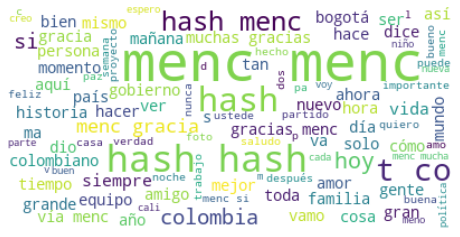

In [105]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(" ".join([j for i in df_final.textos_tratado_sin_palabras_stop for j in i]))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [106]:
df_token = df_final[["sexo", "Rango Edad", "Clase Agrupada Profesión", "texto_tokenizado", 
                     'cantidad_textos_tratado_sin_palabras_stop', 'max_long_palabra', 
                     "nivel_ingreso"]]
df_token.head()

,sexo,Rango Edad,Clase Agrupada Profesión,texto_tokenizado,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra,nivel_ingreso
3376511,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, ener, nuev, masacr, colombi, vez, casan...",9,8,bajo
3376511,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, necesit, niñ, colegi, estudi, edifici, ...",8,10,bajo
3376511,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, verd, justici, voz, nunc, dej, escuch, ...",9,8,bajo
3376511,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, maner, rap, inconvenient, logr, retorn,...",9,14,bajo
3376511,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, necesit, respons, debacl, electoral, as...",8,15,bajo


In [107]:
palabras = set(j for i in df_token.texto_tokenizado  for j in i)
total_palabras =  len(palabras)

In [108]:
total_palabras

33202

In [109]:
from tensorflow import keras

## Paso 10. Conversión a Dummies las variables Género, Rango de Edad y Profesión y Ejecución de Modelos de Machine Learning y Boosting

## Modelos ML
Mediante la creación de un pipeline se ejecutaron modelos de regresión logística, clasificación bayesiana y XGBoosting buscando encontrar los parametros de mejor desempeño en las variables Género, Edad, Profesión y Nivel de Ingresos, concluyendo lo siguiente:

1. El modelo más adecuado para clasificar la variables género en ML es el XGB con un accuracy de 64%.
2. El modelo más adecuado para clasificar la variables edad en ML es el XGB con un accuracy de 43.52%.
3. El modelo más adecuado para clasificar la variables profesión en ML es el XGB con un accuracy de 41%.
3. El modelo más adecuado para clasificar la variables nivel de ingreso en ML es el XGB con un accuracy de 88.51%.

In [112]:
df_dummies = pd.get_dummies(df_token[["sexo","Rango Edad","Clase Agrupada Profesión"]])

for col in df_token.columns: 
    df_dummies[col] = df_token[col]

df_def = df_dummies.copy()
df_def.head()

,sexo_H,sexo_M,Rango Edad_20-30,Rango Edad_30-40,Rango Edad_40-50,Rango Edad_>50,Clase Agrupada Profesión_Abogado,Clase Agrupada Profesión_Actor/Actriz/Cantante/Musico,Clase Agrupada Profesión_Asesor Espiritual,Clase Agrupada Profesión_Biologo,...,Clase Agrupada Profesión_Politico,Clase Agrupada Profesión_Profesor,Clase Agrupada Profesión_Sociologia/Antropología/Filosofia,sexo,Rango Edad,Clase Agrupada Profesión,texto_tokenizado,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra,nivel_ingreso
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, ener, nuev, masacr, colombi, vez, casan...",9,8,bajo
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, necesit, niñ, colegi, estudi, edifici, ...",8,10,bajo
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, verd, justici, voz, nunc, dej, escuch, ...",9,8,bajo
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, maner, rap, inconvenient, logr, retorn,...",9,14,bajo
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,H,40-50,Comunicador Social/Periodista/Presentador/Modelo,"[hash, necesit, respons, debacl, electoral, as...",8,15,bajo


In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, normalize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
#from yellowbrick.cluster import SilhouetteVisualizer
#from sklearn.metrics import plot_confusion_matrix 
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix 
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score
import random as r
from matplotlib import pyplot
# from plotly import graph_objs as go
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import Ellipse, Polygon

In [243]:
def ML_models (X_train, y_train):

  pipelines = {
    'logit' : Pipeline([('normalizer', Normalizer()), ('LogisticRegression', LogisticRegression())]) ,
    'gnb' : Pipeline([('normalizer', Normalizer()), ('Gaussian',GaussianNB())]) , 
    'xgb' : Pipeline([('normalizer', Normalizer()), ('xgboost', xgb.XGBClassifier(num_class=len(y_train.unique()), 
                                                                                  n_jobs = -1,
                                                                                  objective = 'multi:softmax', 
                                                                                  eval_metric = 'mlogloss', 
                                                                                  tree_method='approx', 
                                                                                  scale_pos_weight=1))])
  }

  logit_hyperparameters ={
      'LogisticRegression__penalty' : ['l2']
  }
  
  xgb_hyperparameters = { 
    'xgboost__learning_rate': [0.1, 0.2], 
    'xgboost__n_estimators': [ (i*100) + 50  for i in range(3,6)], 
    'xgboost__max_depth': [i for i in range(6,9)]
  }   

  hyperparametros = {
    'logit' : logit_hyperparameters,
    'xgb' : xgb_hyperparameters
  }

  #params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

  modelos = {}

  for name, pipeline in pipelines.items():
    
    print("fitting:", name)
    if name != 'gnb':
      #cross-validation 
      model = GridSearchCV(pipeline, hyperparametros[name],scoring= 'accuracy', cv=5, n_jobs=-1)
    
      # fit model 
      model.fit(X_train, y_train)
      modelos[name] = model
    else:
      # fit model 
      desempeño=cross_val_score(pipeline, X_train, y_train, cv=3)
      model = pipeline.fit(X_train, y_train)
      modelos[name] = model

    print("Entrenamiento", name, "Completado.")

  for name, model in modelos.items():
    if name != 'gnb':
      print(name, abs(model.best_score_))
    else:
      print(name, np.mean(desempeño) )
  return modelos

In [245]:
INPUT_LENGTH = 25 # Un tweet máximos 25 palabras
EMBED_DIM = 128
MAX_LEN = 200
tokenizer = keras.preprocessing.text.Tokenizer(num_words = total_palabras)
tokenizer.fit_on_texts(df_token.texto_tokenizado)
sequences = tokenizer.texts_to_sequences(df_token.texto_tokenizado)
texto = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = INPUT_LENGTH
)

## Genero

In [246]:
y_sexo = df_token['sexo'].apply(lambda y : transformar_y(df_token['sexo'])[y])
X=df_def[['cantidad_textos_tratado_sin_palabras_stop', 'max_long_palabra']].reset_index().merge(pd.DataFrame(texto), left_index=True, right_index=True).set_index("index")

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sexo, 
                                                      test_size=0.2, 
                                                      random_state=123, 
                                                      stratify= y_sexo)

In [248]:
X.head()

,cantidad_textos_tratado_sin_palabras_stop,max_long_palabra,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
index,,,,,,,,,,,,,,,,,,,,,
3376511,9,8,0,0,0,0,0,0,0,0,...,0,2,1014,14,1152,11,95,4933,380,210
3376511,8,10,0,0,0,0,0,0,0,0,...,0,0,2,120,102,761,253,3266,7943,1818
3376511,9,8,0,0,0,0,0,0,0,0,...,0,2,114,438,594,129,38,130,24,636
3376511,9,14,0,0,0,0,0,0,0,0,...,0,2,339,826,3267,137,2320,50,1985,17191
3376511,8,15,0,0,0,0,0,0,0,0,...,0,0,2,120,522,6639,574,1078,522,1005


In [249]:
X.shape, y_sexo.shape

((97385, 27), (97385,))

In [250]:
sexo_modelos = ML_models(X_train, y_train)

fitting: logit
Entrenamiento logit Completado.
fitting: gnb
Entrenamiento gnb Completado.
fitting: xgb
[22:43:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Entrenamiento xgb Completado.
logit 0.6171638473976089
gnb 0.5687609476063448
xgb 0.6406916037028634


In [251]:
def evaluacion_modelos (modelos, X_test, y_test, modelo):
  y_pred = modelos[modelo].predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(modelos[modelo], X_test, y_test, display_labels= y_test.unique().tolist());

              precision    recall  f1-score   support

           0       0.66      0.88      0.76     12047
           1       0.58      0.27      0.37      7430

    accuracy                           0.65     19477
   macro avg       0.62      0.58      0.56     19477
weighted avg       0.63      0.65      0.61     19477



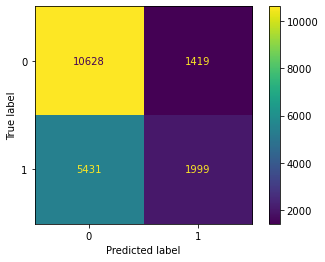

In [252]:
evaluacion_modelos(sexo_modelos, X_test, y_test, 'xgb')

In [253]:
##funcion encoder de las variables y sus respectivos significados 
def transformar_y (y): 
  return {clase : n for n,clase in enumerate(y.unique())}
def diccionario_y (y): 
  return {n : clase for n,clase in enumerate(y.unique())}

## Profesión

In [254]:
y_profesion = df_token['Clase Agrupada Profesión'].apply(lambda y : transformar_y(df_token['Clase Agrupada Profesión'])[y])
X_train, X_test, y_train, y_test = train_test_split(X, y_profesion, 
                                                      test_size=0.2, 
                                                      random_state=123, 
                                                      stratify= y_profesion)

In [255]:
profesion_modelos = ML_models(X_train, y_train)

fitting: logit
Entrenamiento logit Completado.
fitting: gnb
Entrenamiento gnb Completado.
fitting: xgb
[04:15:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Entrenamiento xgb Completado.
logit 0.3136519717666394
gnb 0.005070057785741289
xgb 0.41004772728412914


              precision    recall  f1-score   support

           0       0.40      0.64      0.49      6004
           1       0.66      0.15      0.24       958
           2       0.90      0.18      0.30       149
           3       0.42      0.34      0.38      2586
           4       0.69      0.17      0.27      1235
           5       0.90      0.19      0.32       191
           6       0.43      0.54      0.48      4928
           7       0.80      0.15      0.25       437
           8       0.94      0.16      0.28        97
           9       0.64      0.16      0.25      1138
          10       0.85      0.20      0.32        87
          11       0.88      0.16      0.27       309
          12       0.57      0.19      0.28      1109
          13       0.88      0.15      0.25       103
          14       0.85      0.18      0.30       121
          15       1.00      0.08      0.15        25

    accuracy                           0.43     19477
   macro avg       0.74   

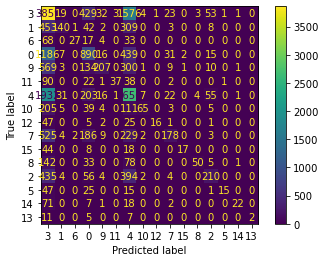

In [256]:
evaluacion_modelos(profesion_modelos, X_test, y_test, 'xgb')

## Edad

In [257]:
y_edades = df_token['Rango Edad'].apply(lambda y : transformar_y(df_token['Rango Edad'])[y])
X_train, X_test, y_train, y_test = train_test_split(X, y_edades, 
                                                      test_size=0.2, 
                                                      random_state=123, 
                                                      stratify= y_edades)

In [258]:
edades_modelos = ML_models(X_train, y_train)

fitting: logit
Entrenamiento logit Completado.
fitting: gnb
Entrenamiento gnb Completado.
fitting: xgb
[05:53:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Entrenamiento xgb Completado.
logit 0.35408421067390256
gnb 0.23615128449187803
xgb 0.4352698013933768


              precision    recall  f1-score   support

           0       0.42      0.40      0.41      5822
           1       0.47      0.49      0.48      5649
           2       0.44      0.55      0.49      6217
           3       0.61      0.16      0.25      1789

    accuracy                           0.45     19477
   macro avg       0.49      0.40      0.41     19477
weighted avg       0.46      0.45      0.44     19477



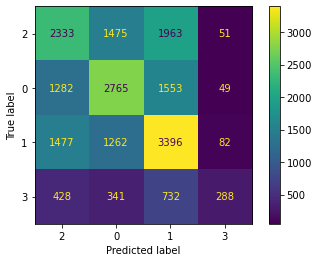

In [259]:
evaluacion_modelos(edades_modelos, X_test, y_test, 'xgb')

In [260]:
df_def.dtypes

sexo_H                                                                        uint8
sexo_M                                                                        uint8
Rango Edad_20-30                                                              uint8
Rango Edad_30-40                                                              uint8
Rango Edad_40-50                                                              uint8
Rango Edad_>50                                                                uint8
Clase Agrupada Profesión_Abogado                                              uint8
Clase Agrupada Profesión_Actor/Actriz/Cantante/Musico                         uint8
Clase Agrupada Profesión_Asesor Espiritual                                    uint8
Clase Agrupada Profesión_Biologo                                              uint8
Clase Agrupada Profesión_Cocinero/Chef                                        uint8
Clase Agrupada Profesión_Comunicador Social/Periodista/Presentador/Modelo   

## Nivel de Ingresos

In [261]:
y_ing = df_token.nivel_ingreso.apply(lambda y : transformar_y(df_token.nivel_ingreso)[y])
X_final=df_def[[i for i in df_def.columns if df_def[i].dtypes != object and 'nivel_ingreso' != i ]].reset_index().merge(pd.DataFrame(texto), left_index=True, right_index=True).set_index("index")

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_ing, 
                                                      test_size=0.2, 
                                                      random_state=123, 
                                                      stratify= y_ing)

In [263]:
X_final.head()

,sexo_H,sexo_M,Rango Edad_20-30,Rango Edad_30-40,Rango Edad_40-50,Rango Edad_>50,Clase Agrupada Profesión_Abogado,Clase Agrupada Profesión_Actor/Actriz/Cantante/Musico,Clase Agrupada Profesión_Asesor Espiritual,Clase Agrupada Profesión_Biologo,...,15,16,17,18,19,20,21,22,23,24
index,,,,,,,,,,,,,,,,,,,,,
3376511,1,0,0,0,1,0,0,0,0,0,...,0,2,1014,14,1152,11,95,4933,380,210
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,2,120,102,761,253,3266,7943,1818
3376511,1,0,0,0,1,0,0,0,0,0,...,0,2,114,438,594,129,38,130,24,636
3376511,1,0,0,0,1,0,0,0,0,0,...,0,2,339,826,3267,137,2320,50,1985,17191
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,2,120,522,6639,574,1078,522,1005


In [264]:
ingresos_modelos = ML_models(X_train, y_train)

fitting: logit
Entrenamiento logit Completado.
fitting: gnb
Entrenamiento gnb Completado.
fitting: xgb
[07:40:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Entrenamiento xgb Completado.
logit 0.46540792276261095
gnb 0.4477974560853806
xgb 0.8815782786104647


              precision    recall  f1-score   support

           0       0.88      0.87      0.88      6010
           1       0.75      0.88      0.81      4780
           2       0.97      0.88      0.93      8687

    accuracy                           0.88     19477
   macro avg       0.87      0.88      0.87     19477
weighted avg       0.89      0.88      0.88     19477



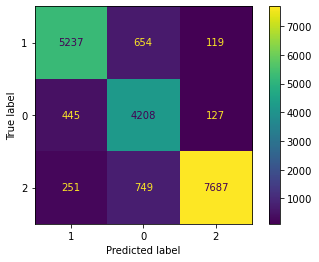

In [265]:
evaluacion_modelos(ingresos_modelos, X_test, y_test, 'xgb')

## Paso 11.  Ejecución de Modelos de Deep Learning -Redes Neuronales para la Variable Género

a. Se separan las variables a tener en cuenta dentro del modelo y la variable de respuesta (Género).  
b. Se tokenizan los textos usando preprocesamiento de Keras.  
c. Se separa la base de entrenamiento y la base de prueba.  
d. Se corre el modelo GRU con función de activación SoftMax, optimizador Adam y función de pérdida categorical_crossentropy y 20 épocas.  
e. Se corre el modelo LSTM con función de activación SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.  
f. Se corre el modelo RNN - Bidirectional layers con funcion de activación de salida SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.  
g. Se corre el modelo Conv1 layers con función de activación en las ocultas relu y en la funcion de activación de salida SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.

Concluyendo que el modelo más adecuado para clasificar la variables género es el GRU con un accuracy de 65.44%.

1.1. GRU

In [266]:
from tensorflow.keras.utils import to_categorical
X = df_token.texto_tokenizado
y = pd.get_dummies(df_token.sexo).values

In [267]:
INPUT_LENGTH = 25 # Un tweet máximos 25 palabras
EMBED_DIM = 128
MAX_LEN = 200

# Creamos tokenizador
tokenizer = keras.preprocessing.text.Tokenizer(num_words = total_palabras)
tokenizer.fit_on_texts(df_token.texto_tokenizado)
sequences = tokenizer.texts_to_sequences(df_token.texto_tokenizado)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = INPUT_LENGTH
)

In [268]:
print('Tamaño X:', X.shape)
print('Tamaño y:', y.shape)

Tamaño X: (97385, 25)
Tamaño y: (97385, 2)


In [269]:
# Separamos train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

In [271]:
# Definimos parámetros para el modelo
DROPOUT_VAL = 0.6
BATCH_SIZE = 16
DENSE_DIM = 2
UNITS = 700
EPOCHS = 20

# Creamos el modelo
layers = [
     keras.layers.Embedding(total_palabras,
                            EMBED_DIM,
                            input_length=INPUT_LENGTH),
     keras.layers.SpatialDropout1D(DROPOUT_VAL),
     keras.layers.GRU(UNITS,
                      dropout=DROPOUT_VAL,
                      recurrent_dropout=0),
     keras.layers.Dense(DENSE_DIM,
                        activation='softmax')

]

model = keras.models.Sequential(layers)

# Compilamos modelo
history = model.compile(optimizer = 'adam',
                         loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

# Añadimos faststopping

callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                          mode = 'min',
                                          verbose = 0,
                                          patience = 3)

checkpoint_1 = keras.callbacks.ModelCheckpoint("best_model1.hdf5",
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='auto',
                                save_weights_only=False)

In [272]:
# Entrenamos
history = model.fit(X_train,
                     y_train,
                     epochs = EPOCHS,
                     validation_data = (X_test, y_test),
                     batch_size = BATCH_SIZE,
                     callbacks = [callback, checkpoint_1])

Epoch 1/20
5174/5174 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6230
Epoch 1: val_accuracy improved from -inf to 0.56640, saving model to best_model1.hdf5
5174/5174 [==============================] - 868s 167ms/step - loss: 0.6536 - accuracy: 0.6230 - val_loss: 0.6754 - val_accuracy: 0.5664
Epoch 2/20
5174/5174 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.6496
Epoch 2: val_accuracy improved from 0.56640 to 0.64554, saving model to best_model1.hdf5
5174/5174 [==============================] - 861s 166ms/step - loss: 0.6259 - accuracy: 0.6496 - val_loss: 0.6299 - val_accuracy: 0.6455
Epoch 3/20
5174/5174 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.6737
Epoch 3: val_accuracy improved from 0.64554 to 0.65094, saving model to best_model1.hdf5
5174/5174 [==============================] - 859s 166ms/step - loss: 0.6020 - accuracy: 0.6737 - val_loss: 0.6318 - val_accuracy: 0.6509
Epoch 4/20
5174/5174 [=========

In [273]:
accuracy_dl_gru = model.evaluate(X_test, y_test)
accuracy_dl_gru

457/457 [==============================] - 33s 72ms/step - loss: 0.6458 - accuracy: 0.6544


[0.6457504630088806, 0.654435932636261]

In [274]:
from sklearn.metrics import classification_report
y_pred_1 = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1)))

457/457 [==============================] - 33s 72ms/step
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      9030
           1       0.58      0.36      0.45      5578

    accuracy                           0.65     14608
   macro avg       0.63      0.60      0.60     14608
weighted avg       0.64      0.65      0.63     14608



In [278]:
from sklearn.metrics import confusion_matrix

def display_cm(y_test, y_pred):    
     sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize = 'true'),
                 annot = True, cmap = 'Blues', fmt='g', cbar=False)
     plt.title('Real vs pred')
     plt.xlabel('Predicted values')
     plt.ylabel('Real values');
    
plt.show()

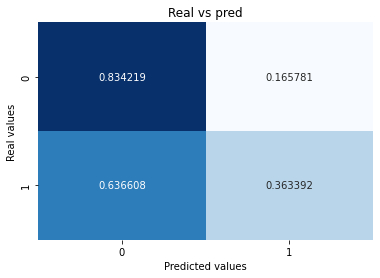

In [279]:
display_cm(y_test, y_pred_1)

1.2. RNN - LSTM layers

In [280]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# Definimos parámetros para el modelo
DROPOUT_VAL = 0.5
BATCH_SIZE = 16
EPOCHS = 20

# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 20, input_length = INPUT_LENGTH),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL),
    keras.layers.Dense(2, activation = 'softmax')   
]

model2 = keras.models.Sequential(layers)

# Compilamos

model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Añadimos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)

# Añadimos checkpoint
metric = 'val_accuracy'

checkpoint_2 = keras.callbacks.ModelCheckpoint("best_model2.hdf5",
                                    monitor = metric,
                                    verbose=1,
                                    save_best_only=True,
                                    mode='auto',
                                    save_weights_only=False)

In [281]:
# Entrenamos

history_2 = model2.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       #validation_split = 0.1,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks=[checkpoint_2, callback])

Epoch 1/20
5174/5174 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.6203
Epoch 1: val_accuracy improved from -inf to 0.62610, saving model to best_model2.hdf5
5174/5174 [==============================] - 116s 22ms/step - loss: 0.6562 - accuracy: 0.6203 - val_loss: 0.6522 - val_accuracy: 0.6261
Epoch 2/20
5174/5174 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.6332
Epoch 2: val_accuracy improved from 0.62610 to 0.63575, saving model to best_model2.hdf5
5174/5174 [==============================] - 110s 21ms/step - loss: 0.6453 - accuracy: 0.6332 - val_loss: 0.6474 - val_accuracy: 0.6357
Epoch 3/20
5172/5174 [============================>.] - ETA: 0s - loss: 0.6384 - accuracy: 0.6429
Epoch 3: val_accuracy improved from 0.63575 to 0.63979, saving model to best_model2.hdf5
5174/5174 [==============================] - 110s 21ms/step - loss: 0.6384 - accuracy: 0.6429 - val_loss: 0.6475 - val_accuracy: 0.6398
Epoch 4/20
5173/5174 [============

In [282]:
# Evaluamos
accuracy_dl_lstm = model2.evaluate(X_test, y_test)
accuracy_dl_lstm

457/457 [==============================] - 3s 5ms/step - loss: 0.6473 - accuracy: 0.6445


[0.6472710371017456, 0.6445098519325256]

In [283]:
# Sacamos classification report
y_pred_2 = model2.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_2, axis=1)))

457/457 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      9030
           1       0.57      0.28      0.37      5578

    accuracy                           0.64     14608
   macro avg       0.62      0.57      0.56     14608
weighted avg       0.63      0.64      0.61     14608



In [284]:
from sklearn.metrics import confusion_matrix

def display_cm(y_test, y_pred):    
    sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize = 'true'),
                annot = True, cmap = 'Blues', fmt='g', cbar=False)
    plt.title('Real vs pred')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');
    
    plt.show()

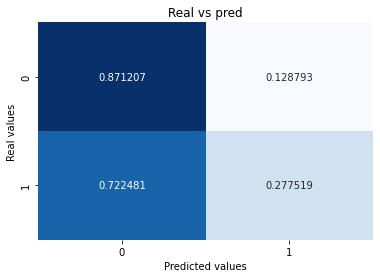

In [285]:
display_cm(y_test, y_pred_2)

1.3. RNN - Bidirectional layers

In [286]:
DROPOUT_VAL = 0.6

layers = [
    keras.layers.Embedding(total_palabras, 40, input_length = INPUT_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(20, dropout = DROPOUT_VAL)),
    keras.layers.Dense(2, activation = 'softmax')
]

model3 = keras.models.Sequential(layers)

# Compilamos modelo
model3.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_3 = keras.callbacks.ModelCheckpoint('best_model3.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [287]:
# Entrenamos
history_3 = model3.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_3])

Epoch 1/20
5172/5174 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6228
Epoch 1: val_accuracy improved from -inf to 0.62774, saving model to best_model3.hdf5
5174/5174 [==============================] - 84s 15ms/step - loss: 0.6539 - accuracy: 0.6228 - val_loss: 0.6539 - val_accuracy: 0.6277
Epoch 2/20
5173/5174 [============================>.] - ETA: 0s - loss: 0.6409 - accuracy: 0.6384
Epoch 2: val_accuracy improved from 0.62774 to 0.63465, saving model to best_model3.hdf5
5174/5174 [==============================] - 79s 15ms/step - loss: 0.6409 - accuracy: 0.6384 - val_loss: 0.6495 - val_accuracy: 0.6347
Epoch 3/20
5171/5174 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.6538
Epoch 3: val_accuracy improved from 0.63465 to 0.64287, saving model to best_model3.hdf5
5174/5174 [==============================] - 79s 15ms/step - loss: 0.6299 - accuracy: 0.6538 - val_loss: 0.6409 - val_accuracy: 0.6429
Epoch 4/20
5173/5174 [===============

In [288]:
# Evaluamos
accuracy_dl_bi = model3.evaluate(X_test, y_test)
accuracy_dl_bi

457/457 [==============================] - 3s 4ms/step - loss: 0.6728 - accuracy: 0.6461


[0.6727741956710815, 0.6460843086242676]

In [289]:
# Sacamos classification report
y_pred_3 = model3.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_3, axis=1)))

457/457 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.67      0.86      0.75      9030
           1       0.57      0.30      0.39      5578

    accuracy                           0.65     14608
   macro avg       0.62      0.58      0.57     14608
weighted avg       0.63      0.65      0.61     14608



In [290]:
from sklearn.metrics import confusion_matrix

def display_cm(y_test, y_pred):    
    sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize = 'true'),
                annot = True, cmap = 'Blues', fmt='g', cbar=False)
    plt.title('Real vs pred')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');
    
    plt.show()

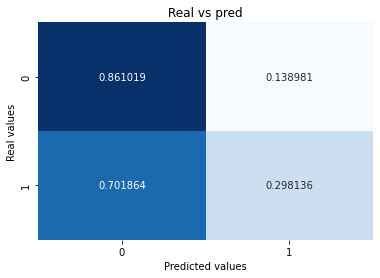

In [291]:
display_cm(y_test, y_pred_3)

1.4. Conv1 layers

In [292]:
# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 40, input_length = INPUT_LENGTH),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.MaxPooling1D(5),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(2, activation = 'softmax')
]

model4 = keras.models.Sequential(layers)

# Compilamos
model4.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_4 = keras.callbacks.ModelCheckpoint('best_model4.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [293]:
# Entrenamos
history_4 = model4.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_4])

Epoch 1/20
5171/5174 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6185
Epoch 1: val_accuracy improved from -inf to 0.61815, saving model to best_model4.hdf5
5174/5174 [==============================] - 42s 8ms/step - loss: 0.6796 - accuracy: 0.6185 - val_loss: 0.6688 - val_accuracy: 0.6182
Epoch 2/20
5171/5174 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6186
Epoch 2: val_accuracy did not improve from 0.61815
5174/5174 [==============================] - 40s 8ms/step - loss: 0.6687 - accuracy: 0.6186 - val_loss: 0.6687 - val_accuracy: 0.6182
Epoch 3/20
5173/5174 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6186
Epoch 3: val_accuracy did not improve from 0.61815
5174/5174 [==============================] - 40s 8ms/step - loss: 0.6686 - accuracy: 0.6186 - val_loss: 0.6686 - val_accuracy: 0.6182
Epoch 4/20
5169/5174 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6185
Epoch 4: val_accur

In [294]:
# Evaluamos
accuracy_dl_conv1d = model4.evaluate(X_test, y_test)
accuracy_dl_conv1d

457/457 [==============================] - 1s 1ms/step - loss: 0.6714 - accuracy: 0.6182


[0.671377420425415, 0.6181544065475464]

In [295]:
# Sacamos classification report
y_pred_4 = model4.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_4, axis=1)))

457/457 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.76      9030
           1       0.00      0.00      0.00      5578

    accuracy                           0.62     14608
   macro avg       0.31      0.50      0.38     14608
weighted avg       0.38      0.62      0.47     14608



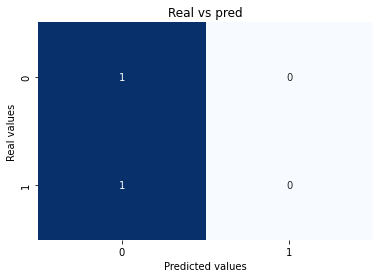

In [296]:
display_cm(y_test, y_pred_4)

In [297]:
# Tabla con accuracy de todos ellos
accuracy_list = [accuracy_dl_gru[1],
                 accuracy_dl_lstm[1],
                 accuracy_dl_bi[1],
                 accuracy_dl_conv1d[1]
          ]

columns = ['NN GRU layers','NN LSTM layers', 'RNN Bidirectional', 'RNN Conv1d']
df_scores = pd.DataFrame(np.c_[columns, round(pd.Series(accuracy_list), 4)], columns = ['Model', 'Val score']).set_index('Model')
df_scores

,Val score
Model,
NN GRU layers,0.6544
NN LSTM layers,0.6445
RNN Bidirectional,0.6461
RNN Conv1d,0.6182


## Paso 12.  Ejecución de Modelos de Deep Learning -Redes Neuronales para la Variable Profesión

a. Se separan las variables a tener en cuenta dentro del modelo y la variable de respuesta (Profesión).  
b. Se separa la base de entrenamiento y la base de prueba.  
c. Se corre el modelo GRU con función de activación SoftMax, optimizador Adam y función de pérdida categorical_crossentropy y 20 épocas.  
d. Se corre el modelo LSTM con función de activación SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.  
e. Se corre el modelo RNN - Bidirectional layers con funcion de activación de salida SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.  
f. Se corre el modelo Conv1 layers con función de activación en las ocultas relu y en la funcion de activación de salida SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.

Concluyendo que el modelo más adecuado para clasificar la variables profesión es el GRU con un accuracy de 44.7%.

Profesiones agrupadas  
Deep learning models  
1.1. GRU 

In [298]:
y = pd.get_dummies(df_token["Clase Agrupada Profesión"]).values

In [299]:
# Separamos train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

In [300]:
len(df_token["Clase Agrupada Profesión"].unique())

16

In [304]:
# Definimos parámetros para el modelo
DROPOUT_VAL = 0.6
BATCH_SIZE = 16
DENSE_DIM = 16
UNITS = 700
EPOCHS = 20

 # Creamos el modelo
layers = [
     keras.layers.Embedding(total_palabras,
                            EMBED_DIM,
                            input_length=INPUT_LENGTH),
     keras.layers.SpatialDropout1D(DROPOUT_VAL),
     keras.layers.GRU(UNITS,
                      dropout=DROPOUT_VAL,
                      recurrent_dropout=0),
     keras.layers.Dense(DENSE_DIM,
                        activation='softmax')

 ]

model_profesion = keras.models.Sequential(layers)

 # Compilamos modelo
history_profesion = model_profesion.compile(optimizer = 'adam',
                         loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

# Añadimos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                          mode = 'min',
                                          verbose = 0,
                                          patience = 3)

checkpoint_1 = keras.callbacks.ModelCheckpoint("best_model1.hdf5",
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='auto',
                                save_weights_only=False)

In [306]:
#Entrenamos
history_profesion = model_profesion.fit(X_train,
                     y_train,
                     epochs = EPOCHS,
                     validation_data = (X_test, y_test),
                     batch_size = BATCH_SIZE,
                     callbacks = [callback, checkpoint_1])

Epoch 1/20
5174/5174 [==============================] - ETA: 0s - loss: 1.8869 - accuracy: 0.3637
Epoch 1: val_accuracy improved from -inf to 0.40423, saving model to best_model1.hdf5
5174/5174 [==============================] - 892s 172ms/step - loss: 1.8869 - accuracy: 0.3637 - val_loss: 1.7886 - val_accuracy: 0.4042
Epoch 2/20
5174/5174 [==============================] - ETA: 0s - loss: 1.7555 - accuracy: 0.4178
Epoch 2: val_accuracy improved from 0.40423 to 0.42292, saving model to best_model1.hdf5
5174/5174 [==============================] - 888s 172ms/step - loss: 1.7555 - accuracy: 0.4178 - val_loss: 1.7256 - val_accuracy: 0.4229
Epoch 3/20
5174/5174 [==============================] - ETA: 0s - loss: 1.6944 - accuracy: 0.4376
Epoch 3: val_accuracy improved from 0.42292 to 0.42737, saving model to best_model1.hdf5
5174/5174 [==============================] - 889s 172ms/step - loss: 1.6944 - accuracy: 0.4376 - val_loss: 1.7090 - val_accuracy: 0.4274
Epoch 4/20
5174/5174 [=========

In [307]:
accuracy_dl_gru = model_profesion.evaluate(X_test, y_test)
accuracy_dl_gru

457/457 [==============================] - 36s 77ms/step - loss: 1.6746 - accuracy: 0.4477


[1.6745935678482056, 0.4476999044418335]

In [308]:
y_pred_1 = model_profesion.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1)))

457/457 [==============================] - 37s 80ms/step
              precision    recall  f1-score   support

           0       0.40      0.09      0.15       846
           1       0.49      0.57      0.53      3676
           2       0.60      0.04      0.07        83
           3       0.00      0.00      0.00        16
           4       0.42      0.09      0.15        86
           5       0.42      0.68      0.52      4509
           6       0.56      0.20      0.29       846
           7       0.39      0.13      0.19       924
           8       0.75      0.03      0.05       337
           9       0.89      0.12      0.22        64
          10       0.38      0.09      0.15       728
          11       0.62      0.03      0.07       231
          12       0.43      0.28      0.34        68
          13       0.46      0.46      0.46      1938
          14       0.93      0.08      0.16       165
          15       1.00      0.01      0.02        91

    accuracy           

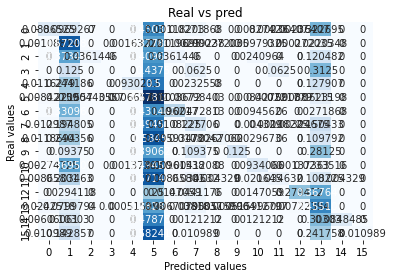

In [309]:
display_cm(y_test, y_pred_1)

1.2. RNN - LSTM layers

In [310]:
# Definimos parámetros para el modelo
DROPOUT_VAL = 0.5
BATCH_SIZE = 16
EPOCHS = 20

# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 20, input_length = INPUT_LENGTH),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL),
    keras.layers.Dense(16, activation = 'softmax')   
]

model2_profesion = keras.models.Sequential(layers)

# Compilamos

model2_profesion.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Añadimos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)

# Añadimos checkpoint
metric = 'val_accuracy'

checkpoint_2 = keras.callbacks.ModelCheckpoint("best_model2.hdf5",
                                    monitor = metric,
                                    verbose=1,
                                    save_best_only=True,
                                    mode='auto',
                                    save_weights_only=False)

In [311]:
# Entrenamos

history_2_profesion = model2_profesion.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       #validation_split = 0.1,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks=[checkpoint_2, callback])

Epoch 1/20
5172/5174 [============================>.] - ETA: 0s - loss: 1.8936 - accuracy: 0.3562
Epoch 1: val_accuracy improved from -inf to 0.38677, saving model to best_model2.hdf5
5174/5174 [==============================] - 127s 24ms/step - loss: 1.8935 - accuracy: 0.3563 - val_loss: 1.8315 - val_accuracy: 0.3868
Epoch 2/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.8129 - accuracy: 0.3978
Epoch 2: val_accuracy improved from 0.38677 to 0.39841, saving model to best_model2.hdf5
5174/5174 [==============================] - 122s 24ms/step - loss: 1.8128 - accuracy: 0.3978 - val_loss: 1.8050 - val_accuracy: 0.3984
Epoch 3/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.7898 - accuracy: 0.4105
Epoch 3: val_accuracy improved from 0.39841 to 0.40430, saving model to best_model2.hdf5
5174/5174 [==============================] - 121s 23ms/step - loss: 1.7898 - accuracy: 0.4105 - val_loss: 1.7943 - val_accuracy: 0.4043
Epoch 4/20
5173/5174 [============

In [312]:
# Evaluamos
accuracy_dl_lstm = model2_profesion.evaluate(X_test, y_test)
accuracy_dl_lstm

457/457 [==============================] - 4s 6ms/step - loss: 1.7541 - accuracy: 0.4249


[1.7540935277938843, 0.4249041676521301]

In [313]:
# Sacamos classification report
y_pred_2 = model2_profesion.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_2, axis=1)))

457/457 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

           0       0.25      0.00      0.00       846
           1       0.45      0.61      0.52      3676
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        86
           5       0.41      0.64      0.50      4509
           6       0.47      0.07      0.12       846
           7       0.00      0.00      0.00       924
           8       0.00      0.00      0.00       337
           9       0.00      0.00      0.00        64
          10       0.56      0.01      0.01       728
          11       0.00      0.00      0.00       231
          12       0.00      0.00      0.00        68
          13       0.43      0.51      0.46      1938
          14       0.00      0.00      0.00       165
          15       0.00      0.00      0.00        91

    accuracy             

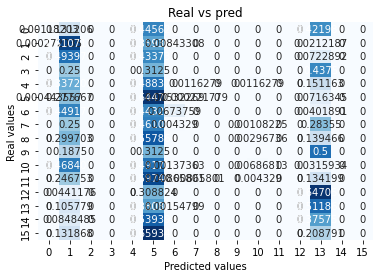

In [314]:
display_cm(y_test, y_pred_2)

1.3. RNN - Bidirectional layers

In [315]:
DROPOUT_VAL = 0.6

layers = [
    keras.layers.Embedding(total_palabras, 40, input_length = INPUT_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(20, dropout = DROPOUT_VAL)),
    keras.layers.Dense(16, activation = 'softmax')
]

model3_profesion = keras.models.Sequential(layers)

# Compilamos modelo
model3_profesion.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_3 = keras.callbacks.ModelCheckpoint('best_model3.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [316]:
# Entrenamos
history_3_profesion = model3_profesion.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_3])

Epoch 1/20
5172/5174 [============================>.] - ETA: 0s - loss: 1.8590 - accuracy: 0.3740
Epoch 1: val_accuracy improved from -inf to 0.39759, saving model to best_model3.hdf5
5174/5174 [==============================] - 91s 17ms/step - loss: 1.8590 - accuracy: 0.3740 - val_loss: 1.8015 - val_accuracy: 0.3976
Epoch 2/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.7725 - accuracy: 0.4114
Epoch 2: val_accuracy improved from 0.39759 to 0.40909, saving model to best_model3.hdf5
5174/5174 [==============================] - 86s 17ms/step - loss: 1.7724 - accuracy: 0.4114 - val_loss: 1.7744 - val_accuracy: 0.4091
Epoch 3/20
5174/5174 [==============================] - ETA: 0s - loss: 1.7319 - accuracy: 0.4294
Epoch 3: val_accuracy improved from 0.40909 to 0.41060, saving model to best_model3.hdf5
5174/5174 [==============================] - 86s 17ms/step - loss: 1.7319 - accuracy: 0.4294 - val_loss: 1.7602 - val_accuracy: 0.4106
Epoch 4/20
5174/5174 [===============

In [317]:
# Evaluamos
accuracy_dl_bi = model3_profesion.evaluate(X_test, y_test)
accuracy_dl_bi

457/457 [==============================] - 3s 4ms/step - loss: 1.7395 - accuracy: 0.4365


[1.7395344972610474, 0.43647316098213196]

In [318]:
# Sacamos classification report
y_pred_3 = model3_profesion.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_3, axis=1)))

457/457 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.27      0.01      0.03       846
           1       0.46      0.60      0.52      3676
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        16
           4       0.50      0.05      0.09        86
           5       0.43      0.63      0.51      4509
           6       0.55      0.12      0.19       846
           7       0.37      0.05      0.09       924
           8       1.00      0.00      0.01       337
           9       0.71      0.08      0.14        64
          10       0.52      0.05      0.08       728
          11       0.31      0.02      0.03       231
          12       1.00      0.01      0.03        68
          13       0.40      0.58      0.48      1938
          14       1.00      0.05      0.09       165
          15       0.00      0.00      0.00        91

    accuracy             

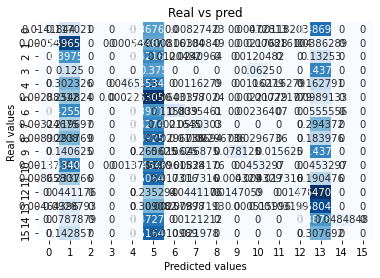

In [319]:
display_cm(y_test, y_pred_3)

1.4. Conv1 layers

In [320]:
# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 40, input_length = INPUT_LENGTH),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.MaxPooling1D(5),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(16, activation = 'softmax')
]

model4_profesion = keras.models.Sequential(layers)

# Compilamos
model4_profesion.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_4 = keras.callbacks.ModelCheckpoint('best_model4.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [321]:
# Entrenamos
history_4_profesion = model4_profesion.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_4])

Epoch 1/20
5168/5174 [============================>.] - ETA: 0s - loss: 2.0399 - accuracy: 0.3070
Epoch 1: val_accuracy improved from -inf to 0.30867, saving model to best_model4.hdf5
5174/5174 [==============================] - 44s 8ms/step - loss: 2.0398 - accuracy: 0.3069 - val_loss: 1.9929 - val_accuracy: 0.3087
Epoch 2/20
5168/5174 [============================>.] - ETA: 0s - loss: 1.9886 - accuracy: 0.3082
Epoch 2: val_accuracy did not improve from 0.30867
5174/5174 [==============================] - 42s 8ms/step - loss: 1.9887 - accuracy: 0.3082 - val_loss: 1.9890 - val_accuracy: 0.3087
Epoch 3/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.9881 - accuracy: 0.3082
Epoch 3: val_accuracy did not improve from 0.30867
5174/5174 [==============================] - 42s 8ms/step - loss: 1.9881 - accuracy: 0.3082 - val_loss: 1.9884 - val_accuracy: 0.3087
Epoch 4/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.9880 - accuracy: 0.3082
Epoch 4: val_accur

In [322]:
# Evaluamos
accuracy_dl_conv1d = model4_profesion.evaluate(X_test, y_test)
accuracy_dl_conv1d

457/457 [==============================] - 1s 2ms/step - loss: 1.9910 - accuracy: 0.3087


[1.990963339805603, 0.30866649746894836]

In [323]:
# Sacamos classification report
y_pred_4 = model4_profesion.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_4, axis=1)))

457/457 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       846
           1       0.00      0.00      0.00      3676
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        86
           5       0.31      1.00      0.47      4509
           6       0.00      0.00      0.00       846
           7       0.00      0.00      0.00       924
           8       0.00      0.00      0.00       337
           9       0.00      0.00      0.00        64
          10       0.00      0.00      0.00       728
          11       0.00      0.00      0.00       231
          12       0.00      0.00      0.00        68
          13       0.00      0.00      0.00      1938
          14       0.00      0.00      0.00       165
          15       0.00      0.00      0.00        91

    accuracy             

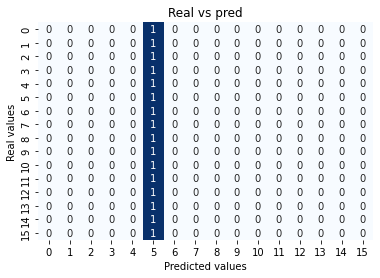

In [324]:
display_cm(y_test, y_pred_4)

In [325]:
# Tabla con accuracy de todos ellos
accuracy_list = [accuracy_dl_gru[1],
                 accuracy_dl_lstm[1],
                 accuracy_dl_bi[1],
                 accuracy_dl_conv1d[1]
          ]

columns = ['NN GRU layers','NN LSTM layers', 'RNN Bidirectional', 'RNN Conv1d']
df_scores = pd.DataFrame(np.c_[columns, round(pd.Series(accuracy_list), 4)], columns = ['Model', 'Val score']).set_index('Model')
df_scores

,Val score
Model,
NN GRU layers,0.4477
NN LSTM layers,0.4249
RNN Bidirectional,0.4365
RNN Conv1d,0.3087


## Paso 13.  Ejecución de Modelos de Deep Learning -Redes Neuronales para la Variable Edad

a. Se separan las variables a tener en cuenta dentro del modelo y la variable de respuesta (Edad).  
b. Se separa la base de entrenamiento y la base de prueba.  
c. Se corre el modelo GRU con función de activación SoftMax, optimizador Adam y función de pérdida categorical_crossentropy y 20 épocas.  
d. Se corre el modelo LSTM con función de activación SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.  
e. Se corre el modelo RNN - Bidirectional layers con funcion de activación de salida SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.  
f. Se corre el modelo Conv1 layers con función de activación en las ocultas relu y en la funcion de activación de salida SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.

Concluyendo que el modelo más adecuado para clasificar la variables edad es la red bidireccional con un accuracy de 43.65%

Rangos Edad    
Deep learning models  
1.1. GRU  

In [326]:
y = pd.get_dummies(df_token["Rango Edad"]).values

In [327]:
# Separamos train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

In [328]:
len(df_token["Rango Edad"].unique())

4

In [333]:
# Definimos parámetros para el modelo
DROPOUT_VAL = 0.6
BATCH_SIZE = 16
DENSE_DIM = 4
UNITS = 700
EPOCHS = 20

 # Creamos el modelo
layers = [
     keras.layers.Embedding(total_palabras,
                            EMBED_DIM,
                            input_length=INPUT_LENGTH),
     keras.layers.SpatialDropout1D(DROPOUT_VAL),
     keras.layers.GRU(UNITS,
                      dropout=DROPOUT_VAL,
                      recurrent_dropout=0),
     keras.layers.Dense(DENSE_DIM,
                        activation='softmax')

 ]

model_edad = keras.models.Sequential(layers)

# Compilamos modelo
history_edad = model_edad.compile(optimizer = 'adam',
                         loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

# # Añadimos faststopping

callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                          mode = 'min',
                                          verbose = 0,
                                          patience = 3)

checkpoint_1 = keras.callbacks.ModelCheckpoint("best_model1.hdf5",
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='auto',
                                save_weights_only=False)

In [336]:
# Entrenamos
history_edad = model_edad.fit(X_train,
                     y_train,
                     epochs = EPOCHS,
                     validation_data = (X_test, y_test),
                     batch_size = BATCH_SIZE,
                     callbacks = [callback, checkpoint_1])

Epoch 1/20
5174/5174 [==============================] - ETA: 0s - loss: 1.2629 - accuracy: 0.3866
Epoch 1: val_accuracy improved from -inf to 0.41012, saving model to best_model1.hdf5
5174/5174 [==============================] - 887s 171ms/step - loss: 1.2629 - accuracy: 0.3866 - val_loss: 1.2382 - val_accuracy: 0.4101
Epoch 2/20
5174/5174 [==============================] - ETA: 0s - loss: 1.2212 - accuracy: 0.4234
Epoch 2: val_accuracy improved from 0.41012 to 0.41539, saving model to best_model1.hdf5
5174/5174 [==============================] - 885s 171ms/step - loss: 1.2212 - accuracy: 0.4234 - val_loss: 1.2360 - val_accuracy: 0.4154
Epoch 3/20
5174/5174 [==============================] - ETA: 0s - loss: 1.1885 - accuracy: 0.4484
Epoch 3: val_accuracy improved from 0.41539 to 0.42778, saving model to best_model1.hdf5
5174/5174 [==============================] - 886s 171ms/step - loss: 1.1885 - accuracy: 0.4484 - val_loss: 1.2226 - val_accuracy: 0.4278
Epoch 4/20
5174/5174 [=========

In [337]:
accuracy_dl_gru = model_edad.evaluate(X_test, y_test)
accuracy_dl_gru

457/457 [==============================] - 37s 80ms/step - loss: 1.2300 - accuracy: 0.4366


[1.2300481796264648, 0.43661007285118103]

In [338]:
y_pred_1 = model_edad.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1)))

457/457 [==============================] - 37s 81ms/step
              precision    recall  f1-score   support

           0       0.44      0.09      0.15      1357
           1       0.45      0.49      0.47      4697
           2       0.38      0.46      0.42      4344
           3       0.50      0.47      0.48      4210

    accuracy                           0.44     14608
   macro avg       0.44      0.38      0.38     14608
weighted avg       0.44      0.44      0.43     14608



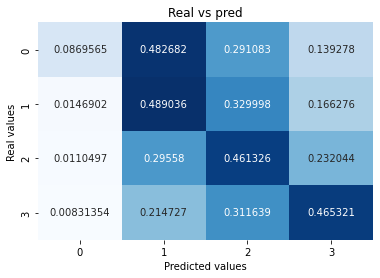

In [339]:
display_cm(y_test, y_pred_1)

1.2. RNN - LSTM layers

In [340]:
# Definimos parámetros para el modelo
DROPOUT_VAL = 0.5
BATCH_SIZE = 16
EPOCHS = 20

# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 20, input_length = INPUT_LENGTH),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL),
    keras.layers.Dense(4, activation = 'softmax')   
]

model2_edad = keras.models.Sequential(layers)

# Compilamos

model2_edad.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Añadimos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)

# Añadimos checkpoint
metric = 'val_accuracy'

checkpoint_2 = keras.callbacks.ModelCheckpoint("best_model2.hdf5",
                                    monitor = metric,
                                    verbose=1,
                                    save_best_only=True,
                                    mode='auto',
                                    save_weights_only=False)

In [341]:
# Entrenamos

history_2_edad = model2_edad.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       #validation_split = 0.1,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks=[checkpoint_2, callback])

Epoch 1/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.2660 - accuracy: 0.3850
Epoch 1: val_accuracy improved from -inf to 0.40074, saving model to best_model2.hdf5
5174/5174 [==============================] - 125s 23ms/step - loss: 1.2660 - accuracy: 0.3850 - val_loss: 1.2487 - val_accuracy: 0.4007
Epoch 2/20
5172/5174 [============================>.] - ETA: 0s - loss: 1.2363 - accuracy: 0.4148
Epoch 2: val_accuracy improved from 0.40074 to 0.40683, saving model to best_model2.hdf5
5174/5174 [==============================] - 119s 23ms/step - loss: 1.2363 - accuracy: 0.4148 - val_loss: 1.2464 - val_accuracy: 0.4068
Epoch 3/20
5172/5174 [============================>.] - ETA: 0s - loss: 1.2214 - accuracy: 0.4257
Epoch 3: val_accuracy improved from 0.40683 to 0.41176, saving model to best_model2.hdf5
5174/5174 [==============================] - 120s 23ms/step - loss: 1.2214 - accuracy: 0.4258 - val_loss: 1.2383 - val_accuracy: 0.4118
Epoch 4/20
5174/5174 [============

In [342]:
# Evaluamos
accuracy_dl_lstm = model2_edad.evaluate(X_test, y_test)
accuracy_dl_lstm

457/457 [==============================] - 4s 6ms/step - loss: 1.2407 - accuracy: 0.4136


[1.2407374382019043, 0.41360896825790405]

In [343]:
# Sacamos classification report
y_pred_2 = model2_edad.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_2, axis=1)))

457/457 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1357
           1       0.41      0.64      0.50      4697
           2       0.34      0.31      0.33      4344
           3       0.52      0.40      0.45      4210

    accuracy                           0.41     14608
   macro avg       0.32      0.34      0.32     14608
weighted avg       0.38      0.41      0.39     14608



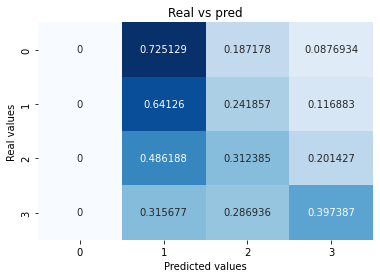

In [344]:
display_cm(y_test, y_pred_2)

1.3. RNN - Bidirectional layers

In [345]:
DROPOUT_VAL = 0.6

layers = [
    keras.layers.Embedding(total_palabras, 40, input_length = INPUT_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(20, dropout = DROPOUT_VAL)),
    keras.layers.Dense(4, activation = 'softmax')
]

model3_edad = keras.models.Sequential(layers)

# Compilamos modelo
model3_edad.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_3 = keras.callbacks.ModelCheckpoint('best_model3.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [346]:
# Entrenamos
history_3_edad = model3_edad.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_3])

Epoch 1/20
5173/5174 [============================>.] - ETA: 0s - loss: 1.2626 - accuracy: 0.3866
Epoch 1: val_accuracy improved from -inf to 0.40505, saving model to best_model3.hdf5
5174/5174 [==============================] - 88s 16ms/step - loss: 1.2626 - accuracy: 0.3866 - val_loss: 1.2468 - val_accuracy: 0.4051
Epoch 2/20
5174/5174 [==============================] - ETA: 0s - loss: 1.2313 - accuracy: 0.4151
Epoch 2: val_accuracy improved from 0.40505 to 0.40841, saving model to best_model3.hdf5
5174/5174 [==============================] - 84s 16ms/step - loss: 1.2313 - accuracy: 0.4151 - val_loss: 1.2420 - val_accuracy: 0.4084
Epoch 3/20
5171/5174 [============================>.] - ETA: 0s - loss: 1.2115 - accuracy: 0.4338
Epoch 3: val_accuracy improved from 0.40841 to 0.40847, saving model to best_model3.hdf5
5174/5174 [==============================] - 83s 16ms/step - loss: 1.2115 - accuracy: 0.4338 - val_loss: 1.2389 - val_accuracy: 0.4085
Epoch 4/20
5171/5174 [===============

In [347]:
accuracy_dl_gru = model3_edad.evaluate(X_test, y_test)
accuracy_dl_gru

457/457 [==============================] - 3s 4ms/step - loss: 1.2406 - accuracy: 0.4288


[1.2406190633773804, 0.4288061261177063]

In [348]:
# Sacamos classification report
y_pred_3 = model3_edad.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_3, axis=1)))

457/457 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.43      0.02      0.04      1357
           1       0.42      0.58      0.48      4697
           2       0.39      0.34      0.36      4344
           3       0.48      0.49      0.49      4210

    accuracy                           0.43     14608
   macro avg       0.43      0.36      0.34     14608
weighted avg       0.43      0.43      0.41     14608



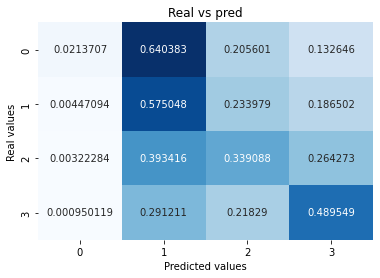

In [349]:
display_cm(y_test, y_pred_3)

1.4. Conv1 layers

In [350]:
# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 40, input_length = INPUT_LENGTH),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.MaxPooling1D(5),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(4, activation = 'softmax')
]

model4_edad = keras.models.Sequential(layers)

# Compilamos
model4_edad.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_4 = keras.callbacks.ModelCheckpoint('best_model4.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [351]:
# Entrenamos
history_4_edad = model4_edad.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_4])

Epoch 1/20
5170/5174 [============================>.] - ETA: 0s - loss: 1.3225 - accuracy: 0.3158
Epoch 1: val_accuracy improved from -inf to 0.32154, saving model to best_model4.hdf5
5174/5174 [==============================] - 44s 8ms/step - loss: 1.3225 - accuracy: 0.3158 - val_loss: 1.3092 - val_accuracy: 0.3215
Epoch 2/20
5172/5174 [============================>.] - ETA: 0s - loss: 1.3080 - accuracy: 0.3169
Epoch 2: val_accuracy did not improve from 0.32154
5174/5174 [==============================] - 43s 8ms/step - loss: 1.3080 - accuracy: 0.3169 - val_loss: 1.3088 - val_accuracy: 0.3215
Epoch 3/20
5172/5174 [============================>.] - ETA: 0s - loss: 1.3079 - accuracy: 0.3179
Epoch 3: val_accuracy did not improve from 0.32154
5174/5174 [==============================] - 43s 8ms/step - loss: 1.3079 - accuracy: 0.3179 - val_loss: 1.3090 - val_accuracy: 0.3215
Epoch 4/20
5170/5174 [============================>.] - ETA: 0s - loss: 1.3078 - accuracy: 0.3183
Epoch 4: val_accur

In [352]:
# Evaluamos
accuracy_dl_conv1d = model4_edad.evaluate(X_test, y_test)
accuracy_dl_conv1d

457/457 [==============================] - 1s 1ms/step - loss: 1.3088 - accuracy: 0.3215


[1.308824062347412, 0.3215361535549164]

In [353]:
# Sacamos classification report
y_pred_4 = model4_edad.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_4, axis=1)))

457/457 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1357
           1       0.32      1.00      0.49      4697
           2       0.00      0.00      0.00      4344
           3       0.00      0.00      0.00      4210

    accuracy                           0.32     14608
   macro avg       0.08      0.25      0.12     14608
weighted avg       0.10      0.32      0.16     14608



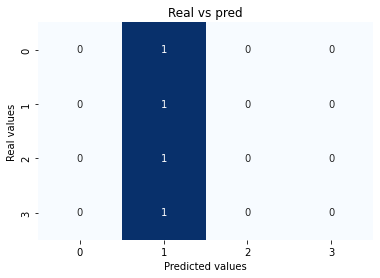

In [354]:
display_cm(y_test, y_pred_4)

In [355]:
# Tabla con accuracy de todos ellos
accuracy_list = [accuracy_dl_gru[1],
                 accuracy_dl_lstm[1],
                 accuracy_dl_bi[1],
                 accuracy_dl_conv1d[1]
          ]

columns = ['NN GRU layers','NN LSTM layers', 'RNN Bidirectional', 'RNN Conv1d']
df_scores = pd.DataFrame(np.c_[columns, round(pd.Series(accuracy_list), 4)], columns = ['Model', 'Val score']).set_index('Model')
df_scores

,Val score
Model,
NN GRU layers,0.4288
NN LSTM layers,0.4136
RNN Bidirectional,0.4365
RNN Conv1d,0.3215


## Paso 14.  Ejecución de Modelos de Deep Learning -Redes Neuronales para la Variable Nivel de Ingresos
a. Se separan las variables a tener en cuenta dentro del modelo y la variable de respuesta (Nivel de Ingresos) teniendo en cuenta las variables sexo, rango de edad y clase agrupada de profesión.
b. Se separa la base de entrenamiento y la base de prueba.
c. Se corre el modelo LSTM con función de activación SoftMax, optimizador rmsprop y función de pérdida categorical_crossentropy y 20 épocas.

El modelo tiene unas variables de desempeño de accuracy de 84.64%, al separarlo por nivel de ingreso se encuentra así:  
    a. Bajo ==> 74.90%  
    b. Medio ==> 90.22%  
    c. Alto ==> 88.19%

Modelo nivel ingresos

In [356]:
y = pd.get_dummies(df_token.iloc[:,-1]).values

In [357]:
df_d=pd.get_dummies(df_token[['sexo', 'Rango Edad', 'Clase Agrupada Profesión']])
df_d.head()

,sexo_H,sexo_M,Rango Edad_20-30,Rango Edad_30-40,Rango Edad_40-50,Rango Edad_>50,Clase Agrupada Profesión_Abogado,Clase Agrupada Profesión_Actor/Actriz/Cantante/Musico,Clase Agrupada Profesión_Asesor Espiritual,Clase Agrupada Profesión_Biologo,...,Clase Agrupada Profesión_Deportista,Clase Agrupada Profesión_Economista/Matematico/Adm. Empresas,Clase Agrupada Profesión_Escritor,Clase Agrupada Profesión_Ingenieria,Clase Agrupada Profesión_Marketing/Publicidad/Modas,Clase Agrupada Profesión_Medicina,Clase Agrupada Profesión_Policia/Militar/Investigador,Clase Agrupada Profesión_Politico,Clase Agrupada Profesión_Profesor,Clase Agrupada Profesión_Sociologia/Antropología/Filosofia
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3376511,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [358]:
df_final_ing=df_d.reset_index().merge(pd.DataFrame(X/total_palabras), left_index=True, right_index=True).set_index("index")
df_final_ing.head()

,sexo_H,sexo_M,Rango Edad_20-30,Rango Edad_30-40,Rango Edad_40-50,Rango Edad_>50,Clase Agrupada Profesión_Abogado,Clase Agrupada Profesión_Actor/Actriz/Cantante/Musico,Clase Agrupada Profesión_Asesor Espiritual,Clase Agrupada Profesión_Biologo,...,15,16,17,18,19,20,21,22,23,24
index,,,,,,,,,,,,,,,,,,,,,
3376511,1,0,0,0,1,0,0,0,0,0,...,0.0,0.00006,0.030540,0.000422,0.034697,0.000331,0.002861,0.148575,0.011445,0.006325
3376511,1,0,0,0,1,0,0,0,0,0,...,0.0,0.00000,0.000060,0.003614,0.003072,0.022920,0.007620,0.098368,0.239233,0.054756
3376511,1,0,0,0,1,0,0,0,0,0,...,0.0,0.00006,0.003434,0.013192,0.017890,0.003885,0.001145,0.003915,0.000723,0.019155
3376511,1,0,0,0,1,0,0,0,0,0,...,0.0,0.00006,0.010210,0.024878,0.098398,0.004126,0.069875,0.001506,0.059786,0.517770
3376511,1,0,0,0,1,0,0,0,0,0,...,0.0,0.00000,0.000060,0.003614,0.015722,0.199958,0.017288,0.032468,0.015722,0.030269


In [359]:
# Separamos train/test
y = pd.get_dummies(df_token["nivel_ingreso"]).values
X_train, X_test, y_train, y_test = train_test_split(df_final_ing, y,
                                                    random_state = 42,
                                                    test_size = 0.15) 

In [360]:
df_final_ing.shape

(97385, 47)

In [361]:
df_final_ing.columns

Index([                                                                   'sexo_H',
                                                                          'sexo_M',
                                                                'Rango Edad_20-30',
                                                                'Rango Edad_30-40',
                                                                'Rango Edad_40-50',
                                                                  'Rango Edad_>50',
                                                'Clase Agrupada Profesión_Abogado',
                           'Clase Agrupada Profesión_Actor/Actriz/Cantante/Musico',
                                      'Clase Agrupada Profesión_Asesor Espiritual',
                                                'Clase Agrupada Profesión_Biologo',
                                          'Clase Agrupada Profesión_Cocinero/Chef',
       'Clase Agrupada Profesión_Comunicador Social/Periodista/Presentador/M

1.2. RNN - LSTM layers

In [362]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# Definimos parámetros para el modelo
DROPOUT_VAL = 0.5
BATCH_SIZE = 16
EPOCHS = 20

# Creamos capas

layers = [
    keras.layers.Embedding(total_palabras, 20, input_length = 47),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL),
    keras.layers.Dense(3, activation = 'softmax')   
]

model_ing = keras.models.Sequential(layers)

# Compilamos

model_ing.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Añadimos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)

# Añadimos checkpoint
metric = 'val_accuracy'

checkpoint_2 = keras.callbacks.ModelCheckpoint("best_model2.hdf5",
                                    monitor = metric,
                                    verbose=1,
                                    save_best_only=True,
                                    mode='auto',
                                    save_weights_only=False)

In [363]:
# Entrenamos

history_ing = model_ing.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       #validation_split = 0.1,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks=[checkpoint_2, callback])

Epoch 1/20
5173/5174 [============================>.] - ETA: 0s - loss: 0.7881 - accuracy: 0.6365
Epoch 1: val_accuracy improved from -inf to 0.77245, saving model to best_model2.hdf5
5174/5174 [==============================] - 203s 38ms/step - loss: 0.7880 - accuracy: 0.6365 - val_loss: 0.5577 - val_accuracy: 0.7725
Epoch 2/20
5173/5174 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.7665
Epoch 2: val_accuracy did not improve from 0.77245
5174/5174 [==============================] - 199s 38ms/step - loss: 0.5536 - accuracy: 0.7665 - val_loss: 0.4743 - val_accuracy: 0.7624
Epoch 3/20
5173/5174 [============================>.] - ETA: 0s - loss: 0.4868 - accuracy: 0.7817
Epoch 3: val_accuracy improved from 0.77245 to 0.81086, saving model to best_model2.hdf5
5174/5174 [==============================] - 199s 39ms/step - loss: 0.4868 - accuracy: 0.7817 - val_loss: 0.4086 - val_accuracy: 0.8109
Epoch 4/20
5173/5174 [============================>.] - ETA: 0s - loss: 

In [364]:
# Evaluamos
accuracy_dl_lstm = model_ing.evaluate(X_test, y_test)
accuracy_dl_lstm

457/457 [==============================] - 5s 10ms/step - loss: 0.3791 - accuracy: 0.8464


[0.37910109758377075, 0.8463855385780334]

In [365]:
# Sacamos classification report
y_pred_5 = model_ing.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_5, axis=1)))

457/457 [==============================] - 5s 9ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      6550
           1       0.90      0.75      0.82      4459
           2       0.71      0.90      0.80      3599

    accuracy                           0.85     14608
   macro avg       0.84      0.84      0.84     14608
weighted avg       0.86      0.85      0.85     14608



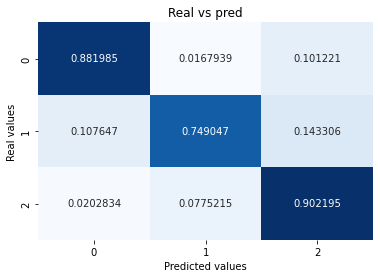

In [366]:
display_cm(y_test, y_pred_5)

# Percepton Multicapa

In [374]:
# Separamos train/test
y = pd.get_dummies(df_token["nivel_ingreso"]).values
X_train, X_test, y_train, y_test = train_test_split(df_final_ing, y,
                                                    random_state = 123,
                                                    test_size = 0.15)

In [375]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier((2, ), random_state = 123, learning_rate_init = 0.1, activation = "logistic")

In [376]:
MLP=model.fit(X_train, y_train)

In [377]:
model.predict(X_train)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [378]:
model.score(X_train, y_train)

0.8543919204609977

## Paso 15. Implementación del Modelo
Se integran en una sola herramienta los modelos seleccionados, de forma tal que al momento en que un usuario ingreso un texto/tweet, genere la clasificación de nivel de ingreso alto, medio o bajo.

Implementación todos los modelos

In [367]:
def implementacion (db):
    db = tratar_texto(db)
    max_long_texto = max([len(i) for i in db.split()])
    conteo_verb = conteo_verbos(db)
    conteo_adj = conteo_adjetivos(db)
    conteo_palabras = len(db.split())
    db = tokenize(db) 
    tokenizer = keras.preprocessing.text.Tokenizer(num_words = total_palabras)
    sequences = tokenizer.texts_to_sequences([db])
    db = keras.preprocessing.sequence.pad_sequences(sequences, maxlen = 25)
    db = pd.DataFrame(db,columns = ["text"+ str(i) for i in pd.DataFrame(db).columns])

    db["cantidad_textos_tratado_sin_palabras_stop"] = conteo_palabras
    db["max_long_texto"] = max_long_texto
    #db["conteo_verbos"] = conteo_verb
    #db["conteo_adjetivos"] = conteo_adj
    cols = ["cantidad_textos_tratado_sin_palabras_stop", "max_long_texto" ] #"conteo_verbos", "conteo_adjetivos"
    cols.extend(["text" + str(i) for i in range(25) ])

    db = db[cols]

    sexo_predict=model2.predict(db) # sexo
    profesion_predict=model2_profesion.predict(db) #profesion 
    edad_predict=model2_edad.predict(db) #edad
    sex= pd.DataFrame(sexo_predict, columns = ["s"+ str(i) for i in pd.DataFrame(sexo_predict).columns])
    prof= pd.DataFrame(profesion_predict, columns = ["p"+ str(i) for i in pd.DataFrame(profesion_predict).columns])
    edad= pd.DataFrame(edad_predict, columns = ["e"+ str(i) for i in pd.DataFrame(edad_predict).columns])
    df1 = sex.merge(edad, how = "left", left_index=True, right_index=True)
    df1 = df1.merge(prof, how = "left", left_index=True, right_index=True)
    df1 = df1.merge(db, how ="left", left_index=True, right_index=True)


   # 0 alto, 1 bajo, 2 medio

    ingresos =  {0:"Alto", 1 :"Bajo", 2 : "Medio"}
    # prob = ingresos_modelos['xgb'].predict(df1).tolist()[0]
    # for x in range(len(prob)):
    #   if prob[x] == max(prob):
    #     ingreso = ingresos[x]
    #     break  
    print(f"Su ingreso estimado es: {ingresos[ingresos_modelos['xgb'].predict(df1)[0]]}") 